# RAPPEL DU SUJET  
  
    
Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

    Réaliser une courte analyse exploratoire.
    Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

## PLAN  
    1. Lecture et visualisation du Dataset  
    2. Cleaning et création de variables  
        A. Lignes  
        B. Colonnes  
        C. Outliers  
    3. Analyse exploratoire  
        A. Analyse univariée  
        B. Analyse multivariée  
        C. Map de Seattle  
    4. Sauvegarde  

# Importation des packages

In [1]:
# Importation des modules requis
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import json
import plotly.express as px
import os
import folium
import folium.plugins

from pandas.plotting import scatter_matrix
from matplotlib.collections import LineCollection

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

# Fonctions

In [2]:
# Fonctions description du fichier
def describe(data, path_file):
    
    # data = dataframe Pandas
    # path_file = nom du fichier 
    lines = len(data)
    cols = len(data.columns)
    print('Nb individus lignes : {}'.format(lines)+'\nNb variables colonnes : {}'.format(cols))
    
    null_nb = data.isna().sum().sum()
    null_percent = round(data.isna().sum().sum()/(data.size),2)
    print('Nb de valeurs nulles : {}'.format(null_nb)+'\nValeurs nulles % : {}'.format(null_percent))
    
    doub_nb = len(data)-len(data.drop_duplicates())
    doub_percent = (len(data)-len(data.drop_duplicates()))/len(data)
    print('Nb doublons variables : {}'.format(doub_nb)+'\nDoublons variables % : {}'.format(doub_percent))
    
    print("Taille du fichier : {} Mb.".format(round((os.path.getsize(path_file))/1e6),2))
    
    types = data.dtypes.value_counts()
    plt.pie(types, labels=types.index, autopct='%1.1f%%')
    plt.title('Répartition des variables par type')
    plt.legend(title='Types', bbox_to_anchor=(1,1))
    plt.show()

In [3]:
# Fonction graphique barres valeurs nulles (colonnes)
def null_col_graph(data):  
    
    # data = dataframe Pandas
    fill_rate = data.isna().sum().divide(data.shape[0]/100).sort_values(ascending=False)
    sns.set(style="darkgrid")
    plt.figure(figsize=(16, 30))
    ax = sns.barplot(y = fill_rate.index, x=fill_rate.values)
    ax.xaxis.set_ticks_position('top')
    plt.title('% de valeurs manquantes par colonne', size=15)
    plt.ylabel('Colonnes')
    plt.xlabel('%')
    plt.show()

In [4]:
# Fonction filtrage par remplissage (colonnes)
def drop_cols(data, threshold):
    
    # data = dataframe Pandas
    # threshold = seuil choisi
    col_fill_rate = data.count() / data.shape[0]
    mask = col_fill_rate > threshold
    cols = col_fill_rate[mask]
    selected_cols = list(cols.index)
    print("Nb de colonnes avec tx de remplissage supérieur à {:.2%} : {} colonnes.".format(threshold, len(selected_cols)))
    return data[selected_cols]

In [5]:
# Fonction affichage taux de remplissage par ligne
def empty_rows(df):
    
    # df = dataframe Pandas
    empty_lines=[]
    for index,row in df.iterrows(): 
        empty_lines.append( (1- row.isna().sum().sum()/df.shape[1])*100)
    df_empty_rows = pd.DataFrame(np.array(empty_lines),columns=['%'])
    print(df_empty_rows.sort_values(by=['%']))
    df_empty_rows['%'].hist(bins=20)
    plt.show()

In [6]:
# Fonction filtrage par taux de remplisage des lignes
def drop_rows(df, threshold):
    
    # df = dataframe Pandas
    # threshold = seuil choisi
    filtered_rows=[]
    data_filtered = df[df.count(axis='columns')/df.shape[1]>threshold].reset_index(drop=True)
    print(data_filtered.shape)
    display(data_filtered)

In [7]:
# Fonction de génération d'un boxplot des emissions de CO2 en fonction d'une variable qualitative
def boxplotsCO2(var,df):
    
    # var = variable qualitative choisie
    # df = dataframe Pandas
    mean=df["TotalGHGEmissions"].mean()
    fig=plt.figure(figsize=[18,7])
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    plt.title("Global gas emissions distribution by {}".format(var),size=16)
    sns.boxplot(x=var, y="TotalGHGEmissions", data=df,color="#cbd1db",width=0.5,showfliers=False,showmeans=True)
    plt.hlines(y=mean,xmin=-0.5,xmax=len(df[var].unique())-0.5,color="#6d788b",ls="--",label="Global mean")

    plt.ylabel(" C02 emissions",size=14)
    plt.xticks(range(0,len(df[var].unique()))
               ,df[var].unique(),rotation=90)
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
# Fonction de génération d'une heatmap de corrélations
def heatmap_corr(df):
    
    # df = dataframe Pandas
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(df.corr(), annot = True, linewidth=0.5, square = True)
    plt.title('Corrélations entre les variables', fontsize=16)

In [9]:
# Fonction analyse distribution features
def feature_distrib(data, feature):
    
    # data = dataframe Pandas
    # feature = groupe de variables à analyser
    for column in feature:
        print('TARGET : {}'.format(column))
        n_bins = 12
        subset = data[column]
        print('INFOS : \n\tmean: {}\n\tmed: {}\n\tmod: {}\n\tvar: {}\n\tstd: {}\n\tskew: {}\n\tkur: {}'
              .format(round(subset.mean(),4),round(subset.median(),4), round(subset.mode()[0],4), round(subset.var(ddof=0),4), round(subset.std(ddof=0),4), round(subset.skew(),4),round(subset.kurtosis(),4)))
        plt.hist(subset,n_bins,label='Infos :', alpha=0.5)
        plt.title(column)
        plt.show()
        subset.plot.box(vert=False)
        plt.title(column)
        plt.show()

In [10]:
# Fonction analyse features
def feature_analysis(data, feature):
    
    for column in feature:
        n_bins = 20
        fig = plt.figure(figsize=(12,7))
        plt.hist(data[column],n_bins)
        plt.title(column)
        plt.show()

In [11]:
# Fonction de suppression des valeurs strictement négatives (variables quantitatives)
def del_neg(feature, data):
    
    # data = dataframe Pandas
    # feature = groupe de variables à analyser
    for column in feature:
        neg_values = data[data[column] <0]
        if(neg_values.shape[0]>0):
            print('Outliers de la variable ' + column)
            display(neg_values)
            data.drop(neg_values.index, inplace=True)
    display(data.shape)

In [12]:
# Fonction de suppression des valeurs négatives ou égales à 0 (variables quantitatives)
def del_neg_equal(feature, data):
    
    # data = dataframe Pandas
    # feature = groupe de variables à analyser
    for column in feature:
        neg_values = data[data[column] <=0]
        if(neg_values.shape[0]>0):
            print('Outliers de la variable ' + column)
            display(neg_values)
            data.drop(neg_values.index, inplace=True)
    display(data.shape)

In [13]:
# Fonction de matrice de corrélation (Pearson)
def corr_analysis(data):
    
    # data = dataframe Pandas
    corr = data.corr(method='pearson')
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,20))
    ax = sns.heatmap(corr, annot=True, mask=mask, center=0, cmap="BrBG")
    plt.title('Matrice des corrélations de Pearson')
    plt.show()

In [14]:
# Fonction d'analyse des outliers par la méthode des IQR    
def outliers_IQR(feature, data):
    
    # data = dataframe Pandas
    # feature = groupe de variables à analyser
    for column in feature:
        i= 0
        quartile_1 = data[column].quantile(0.25)
        quartile_3 = data[column].quantile(0.75)   
        iqr = quartile_3 - quartile_1
        min_value = quartile_1 - 1.5*iqr
        max_value = quartile_3 + 1.5*iqr
        outliers = data[(data[column]>max_value) | (data[column]<min_value)]
        i += outliers.shape[0]
        print('Lower bound : {}'.format(min_value))
        print('Upper bound : {}'.format(max_value))
        print('{} : {} outliers'.format(column,i))
        print('-------------')

In [15]:
# Fonction couleurs dataframe
def colors(val):
    
    # val = seuil choisi
    color = 'red' if val <= 0 else 'green'
    return 'color: %s' % color

# 1. Lecture et visualisation du Dataset

In [16]:
# Ouverture du Dataset
path_file = '2016_Building_Energy_Benchmarking.csv'
dfdata = pd.read_csv(path_file, error_bad_lines=False, low_memory=False)
dfdata.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Nb individus lignes : 3376
Nb variables colonnes : 46
Nb de valeurs nulles : 19952
Valeurs nulles % : 0.13
Nb doublons variables : 0
Doublons variables % : 0.0
Taille du fichier : 1 Mb.


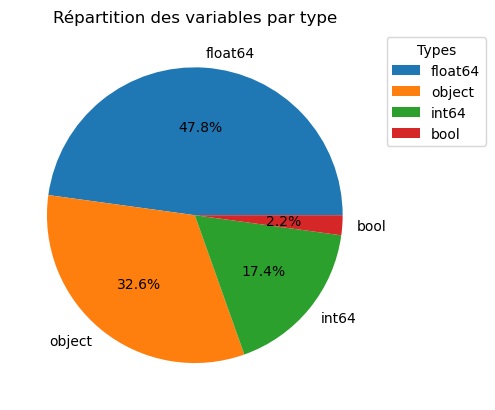

In [17]:
# Informations générales
describe(dfdata, path_file)

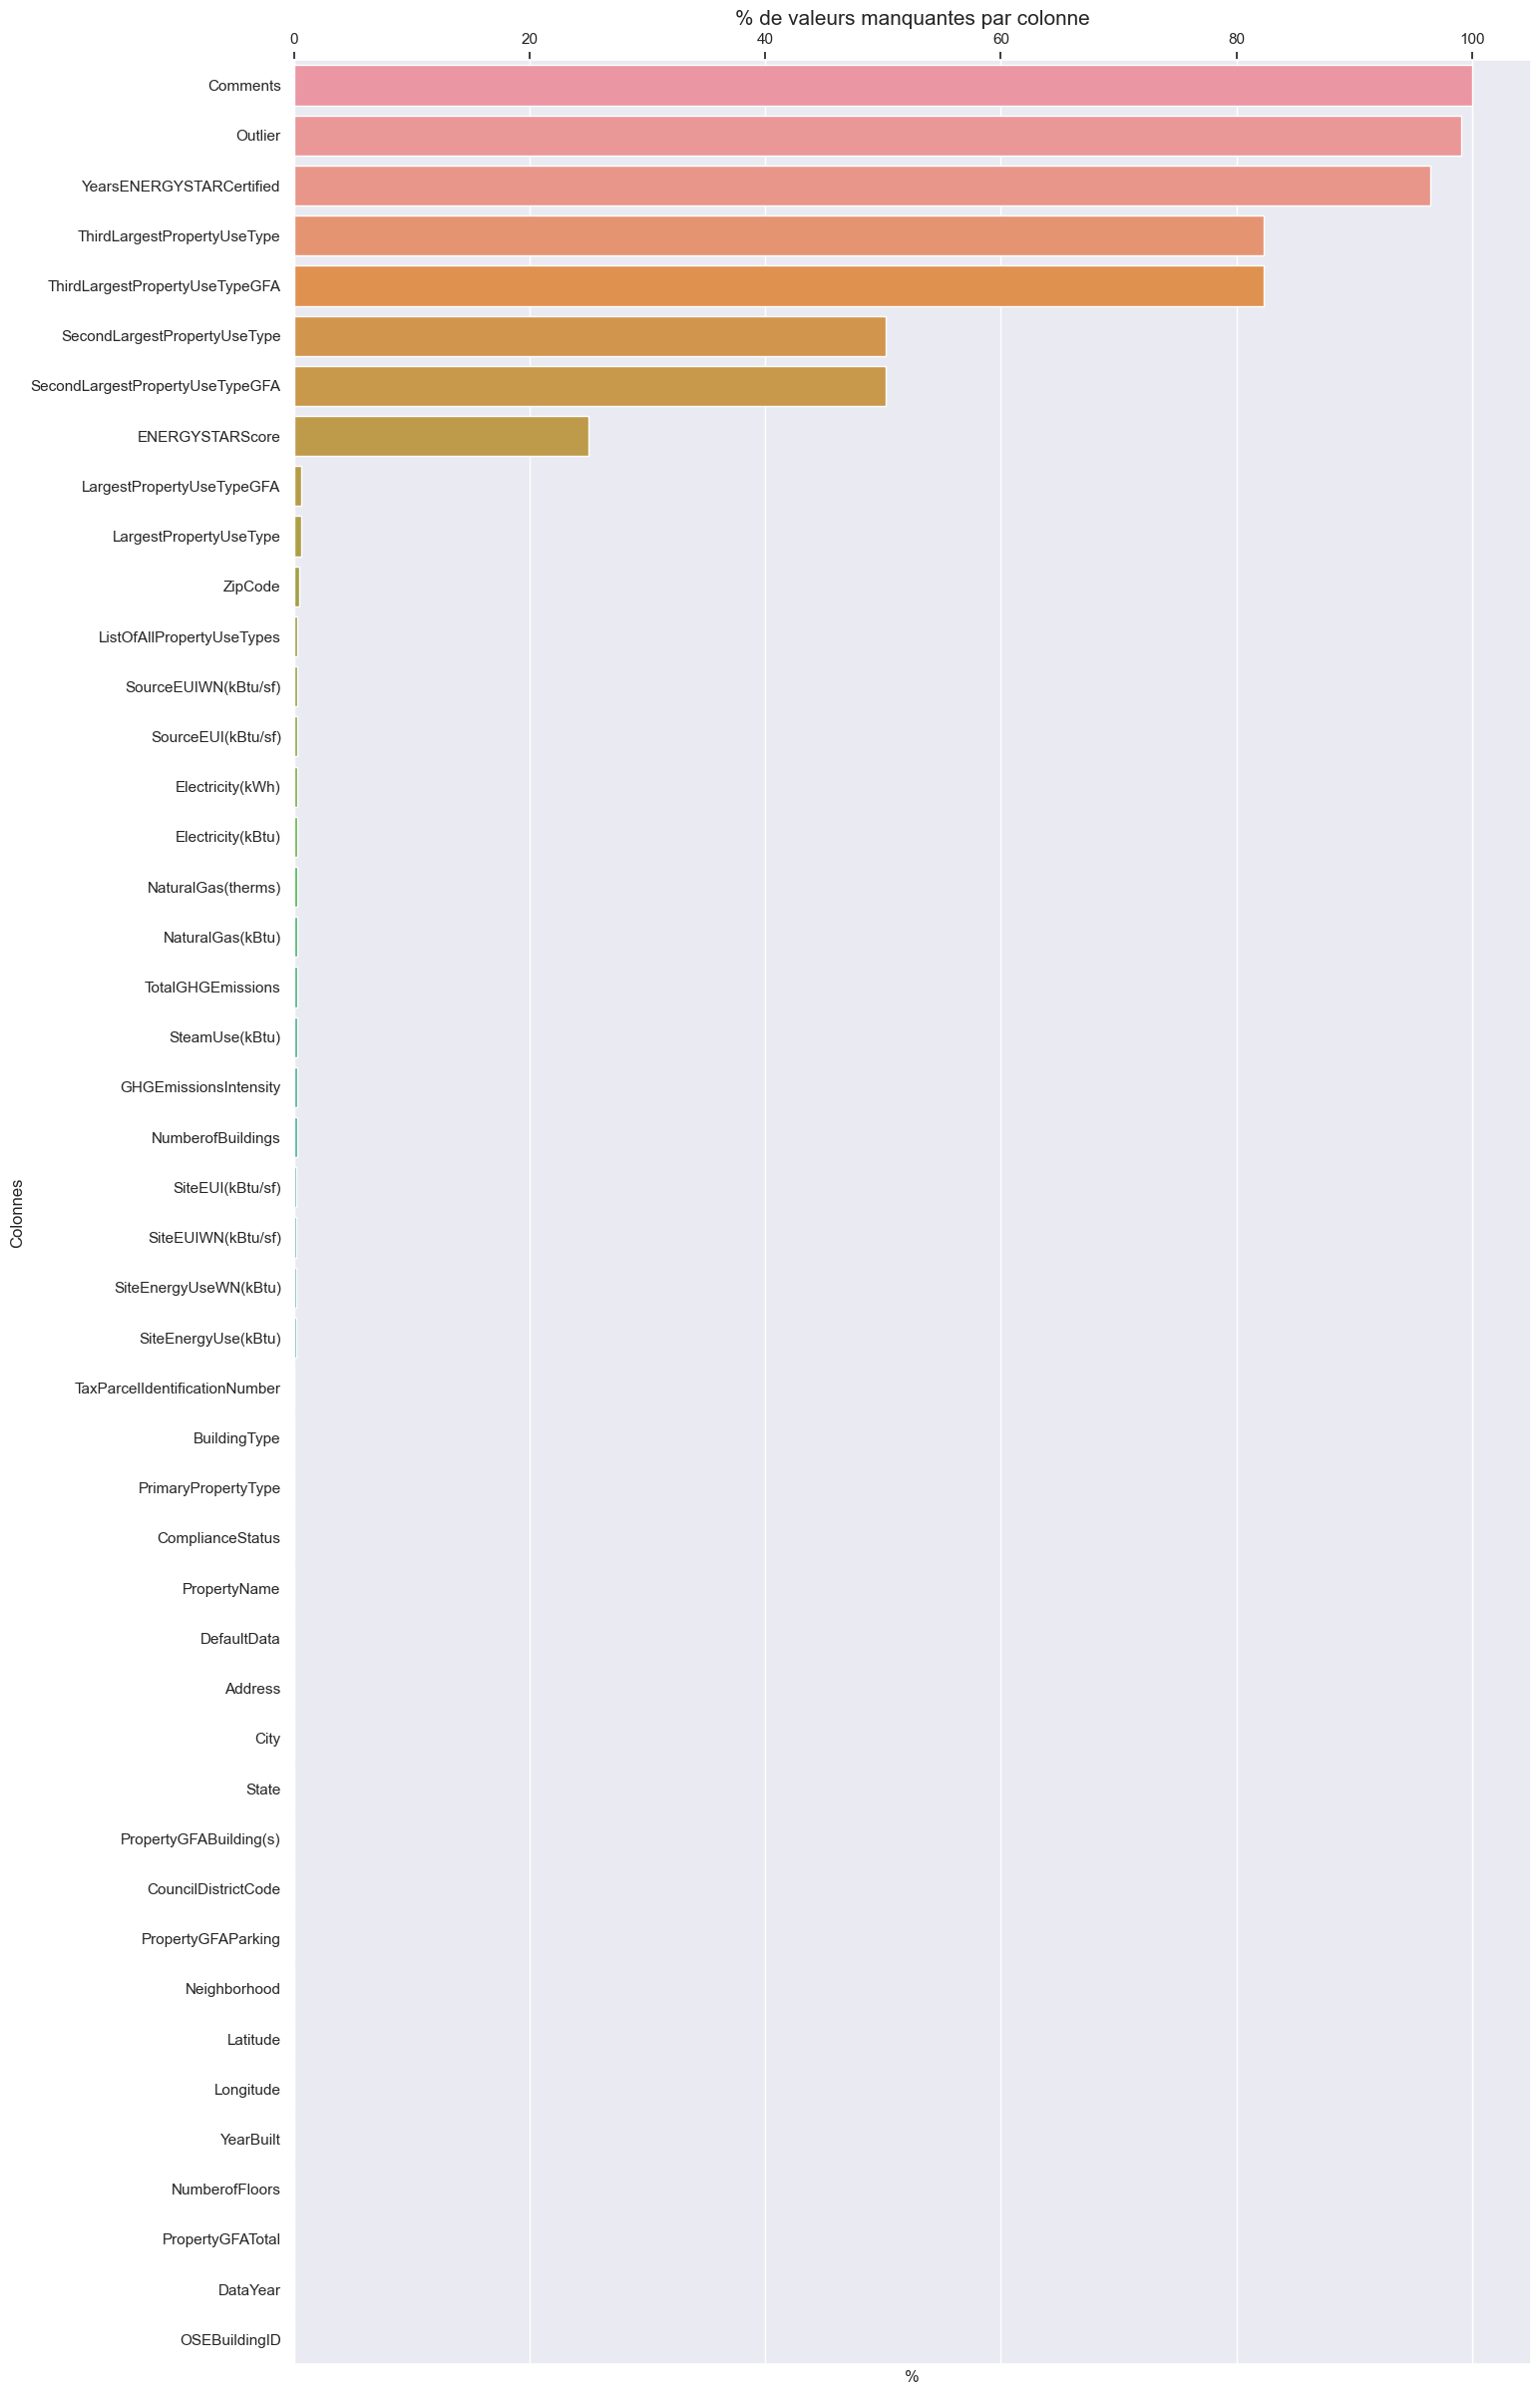

In [18]:
# Valeurs nulles par colonne
null_col_graph(dfdata)

On note que la plupart des colonnes sont complètement remplies. Seules quelques colonnes sont concernées par des taux de remplissage très faibles.

In [19]:
# Vérifions qu'il ne s'agit que de données sur l'année 2016
dfdata['DataYear'].unique()

array([2016], dtype=int64)

Les données sont toutes sur l'année 2016.

# 2. Cleaning du Dataset

## A. Lignes

Observons plus en détail la composition des variables peu remplies (Outlier, ComplianceStatus)

<AxesSubplot:>

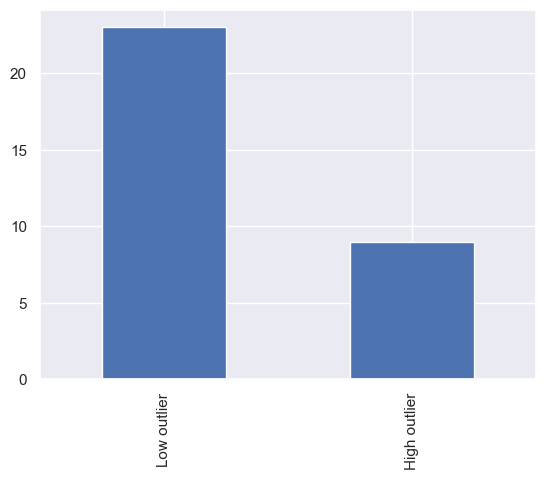

In [20]:
dfdata['Outlier'].value_counts().plot.bar()

Nous conserverons les lignes dont la variable 'Outlier' est nulle.

<AxesSubplot:>

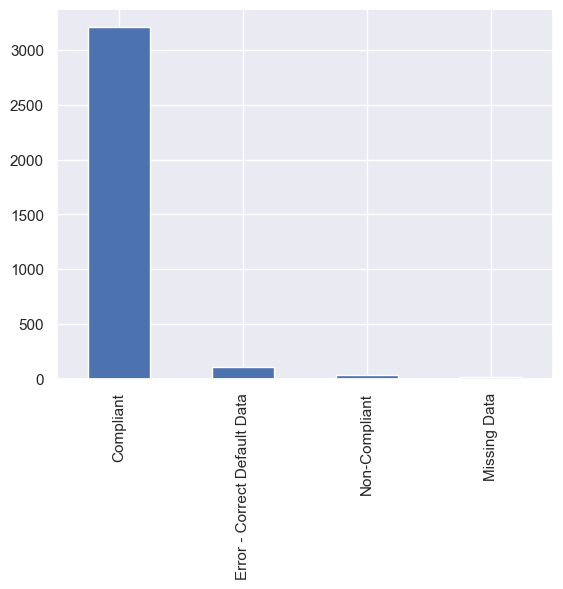

In [21]:
dfdata['ComplianceStatus'].value_counts().plot.bar()

Nous conserverons les lignes dont le statut 'ComplianceStatus' est 'Compliant'.


In [22]:
# Suppression des lignes 'Outliers' et non 'Compliant'
dfdata = dfdata[dfdata['Outlier'].isnull()]
dfdata = dfdata[dfdata['ComplianceStatus'] == 'Compliant']

Analysons le taux de remplissage par ligne.

              %
2351  54.347826
2199  54.347826
1669  54.347826
3186  56.521739
2214  78.260870
...         ...
163   95.652174
209   95.652174
325   95.652174
179   95.652174
185   95.652174

[3211 rows x 1 columns]


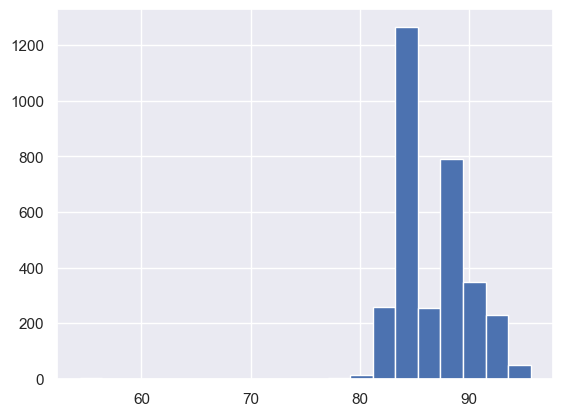

In [23]:
# Contrôle du taux de remplissage des lignes
empty_rows(dfdata)

Nous supprimerons les lignes dont le taux de valeurs nulles est supérieur à 80%.

In [24]:
# Suppression des lignes avec taux de valeurs nulles supérieur à un seuil (ici 80%)
drop_rows(dfdata, 0.8)

(3203, 46)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198,50221,2016,Nonresidential COS,Other,High Point Community Center,6920 34th Ave SW,Seattle,WA,NaN,2524039059,...,1.853347e+05,6.323620e+05,2997.199951,2.997200e+05,False,NaN,Compliant,NaN,20.33,1.11
3199,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3200,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3201,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57


Nous devons nous concentrer sur les bâtiments non résidentiels. Analysons les colonnes 'BuildingType' et 'PrimaryPropertyType'

<AxesSubplot:>

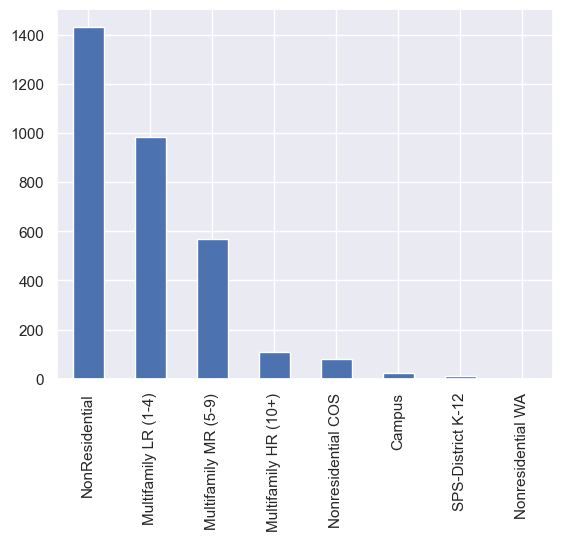

In [25]:
# Différents types de bâtiments : catégories et usages
display(dfdata['BuildingType'].value_counts().plot.bar())

<AxesSubplot:>

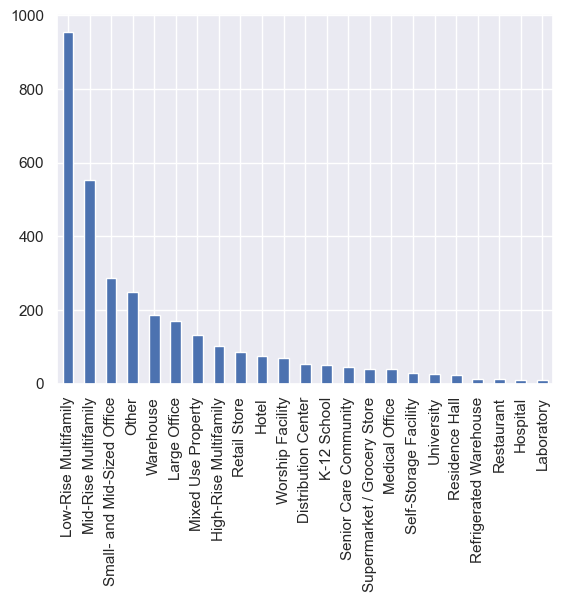

In [26]:
display(dfdata['PrimaryPropertyType'].value_counts().plot.bar())

#### Analyse des types de buildings :  
  
Multifamily = habitation rédisentielle  
Low-rise (LR) / Mid-rise (MR) / High-rise (HR) = taille de l'habitation  
Il y a donc trois types d'habitations résidentielles, classées selon leur taille.  
  
Nous supprimerons toutes les lignes concernant les bâtiments résidentiels (LR, MR and HR).

In [27]:
# Analysons les différentes catégories contenant 'Multifamily'
dfbuildingtype = dfdata[dfdata['BuildingType'].str.contains("Multifamily") & dfdata['PrimaryPropertyType'].str.contains("Multifamily")]
display(dfbuildingtype['BuildingType'].unique())
display(dfbuildingtype['PrimaryPropertyType'].unique())

array(['Multifamily MR (5-9)', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)'], dtype=object)

array(['Mid-Rise Multifamily', 'Low-Rise Multifamily',
       'High-Rise Multifamily'], dtype=object)

In [28]:
# Supprimons toutes les lignes contenant 'Multifamily' dans 'BuildingType' ou dans 'PrimaryPropertyType'
dfdata = dfdata[~dfdata['BuildingType'].str.contains("Multifamily") & ~dfdata['PrimaryPropertyType'].str.contains("Multifamily")]
display(dfdata.shape)

(1546, 46)

## B. Colonnes

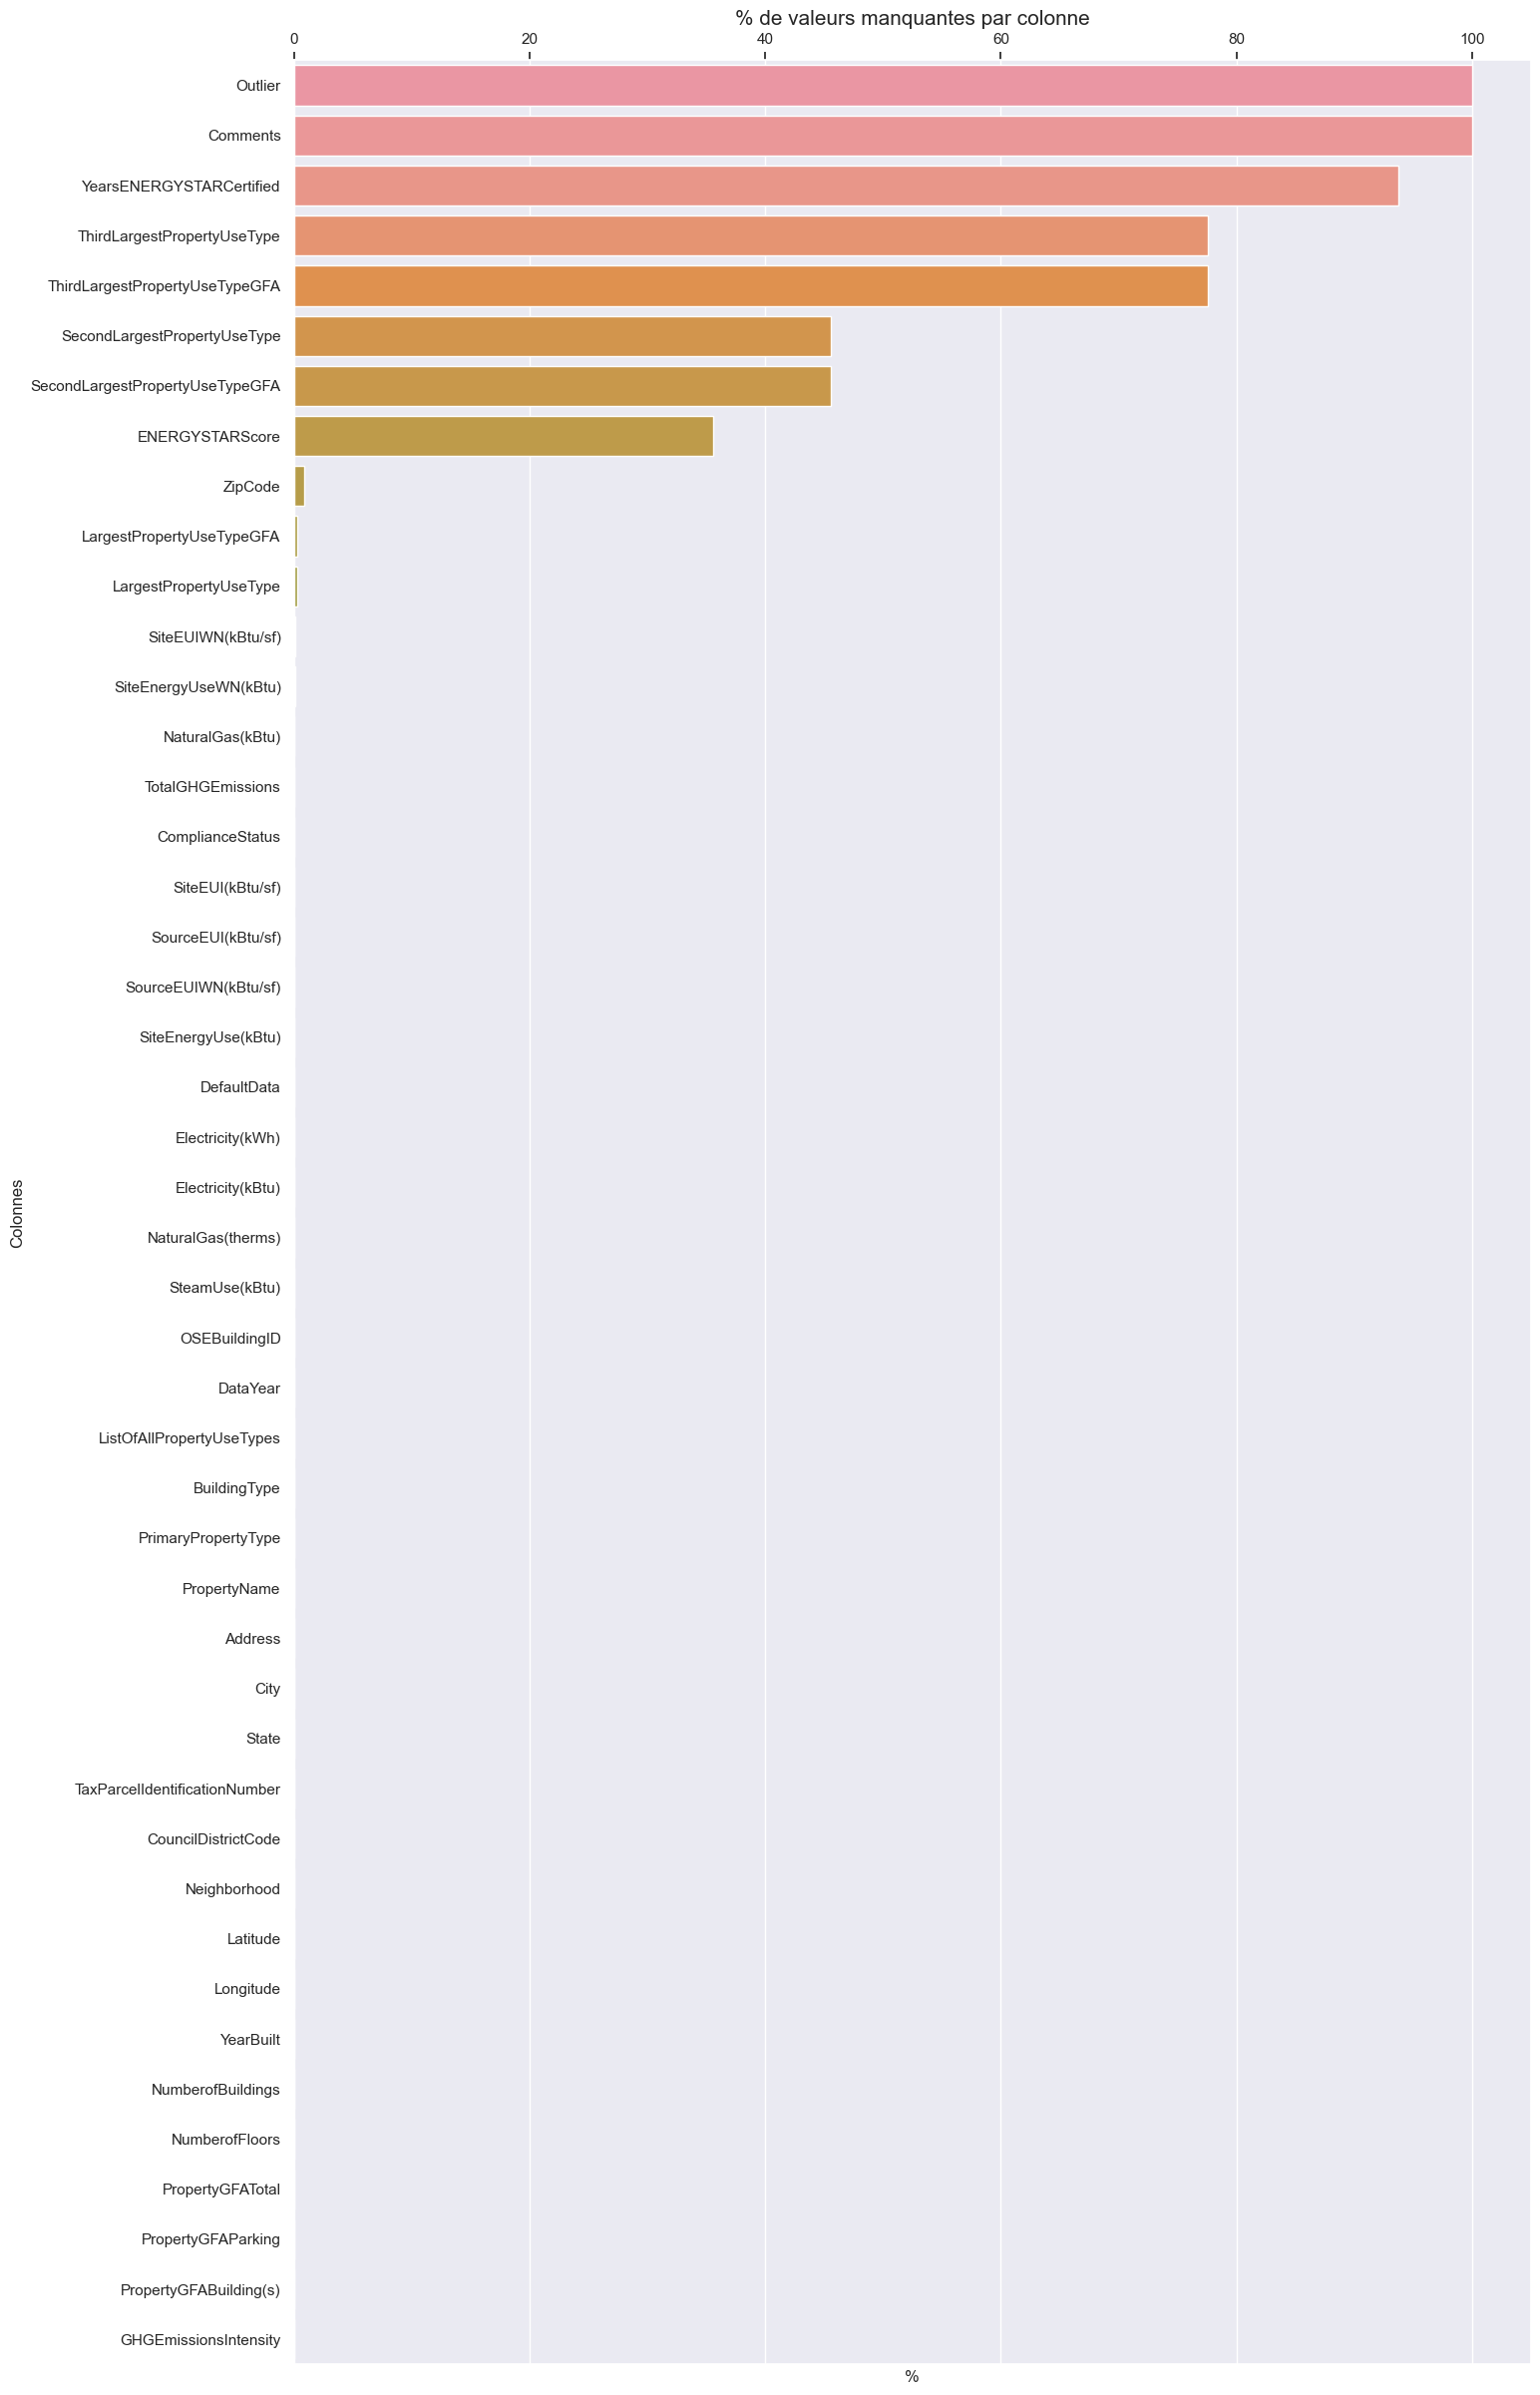

In [29]:
null_col_graph(dfdata)

### Création colonne : âge des bâtiments 

In [30]:
# Transformation âge des batiments : Age = 2016 - YearBuilt
dfdata['Age'] = dfdata['DataYear'] - dfdata['YearBuilt']
dfdata['Age'].unique()

array([ 89,  20,  47,  90,  36,  17, 112,  18,  88,  94,  12,  86,  33,
       109, 100,  31,  15,  25,  38, 110,  22,  61,  24,  55,  26, 116,
        62, 105,  43,  96, 106,  34, 108,  57,  16,  19,  54,  46,   8,
        51,  87,   6,  78,  30,  14,  93,  13,  75,  10, 101,  66,  58,
         7,   5,  45,   9,  65,  52,  63,  79,  50,  59,  48,  92,  11,
        85,  44,  64, 102, 103,  21,  35,  27,  91,  40, 107,  28,  37,
        69,  32,  60, 104,  39,  56,  71,  53,  42,  41,  70,  49,  29,
        67,  76,  84,  68,  23,  98, 111, 114,  95,  77,  72,  99,  74,
       113,   4,   3,  97, 115,  80,  81,   2,   1], dtype=int64)

### Création colonnes : proportions surfaces par types d'utilisations des bâtiments

Afin de faciliter la modélisation ultérieure, nous transformons les surfaces par type d'utilisation en les passant de surfaces brutes à une proportion par rapport à la surface totale, donc comprise entre 0 et 1.

In [31]:
dfdata['prop_GFAParking'] = dfdata['PropertyGFAParking'] / dfdata['PropertyGFATotal']
dfdata['prop_Use1'] = dfdata['LargestPropertyUseTypeGFA'] / (dfdata['LargestPropertyUseTypeGFA']+dfdata['SecondLargestPropertyUseTypeGFA']+dfdata['ThirdLargestPropertyUseTypeGFA'])
dfdata['prop_Use2'] = dfdata['SecondLargestPropertyUseTypeGFA'] / (dfdata['LargestPropertyUseTypeGFA']+dfdata['SecondLargestPropertyUseTypeGFA']+dfdata['ThirdLargestPropertyUseTypeGFA'])
dfdata['prop_Use3'] = dfdata['ThirdLargestPropertyUseTypeGFA'] / (dfdata['LargestPropertyUseTypeGFA']+dfdata['SecondLargestPropertyUseTypeGFA']+dfdata['ThirdLargestPropertyUseTypeGFA'])

### Supression des colonnes inutiles

Quelques définitions utiles :  
    - GHG: greenhouse gas emissions, correspond aux émissions des gazs à effets de serre.  
    - OSE: Seattle Office of Sustainability and Environment.  
    - EUI: Energy Use Intensity.  
    - kBtu: kilo-British thermal unit, 1 kWh = 3.412 kBtu.  
    - sf: square feet, 1m² = 10,7639sf.  
    - WN: weather-normalized, normalisé vis à vis des conditions climatiques.  
    - GFA: Gross floor area, Surface de plancher brute - La surface de plancher couverte (par un toit, même sans mur) totale contenue dans le bâtiment.  
    - therm: mesure énergétique 1thm =100000Btu.

In [32]:
#Analyse des doublons sur les individus 'PropertyName' :
dfdata['PropertyName'].value_counts()[dfdata['PropertyName'].value_counts() >1]

Canal Building      2
Airport Way         2
South Park          2
Bayview Building    2
Name: PropertyName, dtype: int64

In [33]:
# Suppression des doublons identifiés
dfdata.drop_duplicates(subset='PropertyName', inplace=True)

In [34]:
# Colonnes à supprimer
cols_to_drop = ['DataYear',
                'PropertyName',
                'Address',
                'City', 
                'State',
                'YearBuilt',
                'PropertyGFAParking',
                'PropertyGFABuilding(s)',
                'ListOfAllPropertyUseTypes',
                'LargestPropertyUseTypeGFA',
                'SecondLargestPropertyUseType',
                'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseType',
                'ThirdLargestPropertyUseTypeGFA',
                'YearsENERGYSTARCertified',
                'Electricity(kWh)',
                'NaturalGas(therms)',
                'DefaultData',
                'Comments', 
                'ComplianceStatus',
                'Outlier'
               ]
dfdata.drop(cols_to_drop,axis=1, inplace=True)
dfdata

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,...,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
0,1,NonResidential,Hotel,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1.0,...,2003882.00,3.946027e+06,1.276453e+06,249.98,2.83,89,0.000000,NaN,NaN,NaN
1,2,NonResidential,Hotel,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1.0,...,0.00,3.242851e+06,5.145082e+06,295.86,2.86,20,0.145453,0.809918,0.145453,0.044629
2,3,NonResidential,Hotel,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1.0,...,21566554.00,4.952666e+07,1.493800e+06,2089.28,2.19,47,0.205748,NaN,NaN,NaN
3,5,NonResidential,Hotel,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1.0,...,2214446.25,2.768924e+06,1.811213e+06,286.43,4.67,90,0.000000,NaN,NaN,NaN
4,8,NonResidential,Hotel,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1.0,...,0.00,5.368607e+06,8.803998e+06,505.01,2.88,36,0.353115,0.644776,0.355224,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,50221,Nonresidential COS,Other,NaN,2524039059,1,DELRIDGE NEIGHBORHOODS,47.54067,-122.37441,1.0,...,0.00,6.323620e+05,2.997200e+05,20.33,1.11,34,0.000000,NaN,NaN,NaN
3372,50223,Nonresidential COS,Other,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,1.0,...,0.00,3.965461e+05,5.537300e+05,32.17,2.01,12,0.000000,NaN,NaN,NaN
3373,50224,Nonresidential COS,Other,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1.0,...,0.00,1.792159e+06,3.973739e+06,223.54,16.99,42,0.000000,0.576347,0.423653,0.000000
3374,50225,Nonresidential COS,Mixed Use Property,NaN,7883603155,1,GREATER DUWAMISH,47.52832,-122.32431,1.0,...,0.00,3.488702e+05,3.706010e+05,22.11,1.57,27,0.000000,0.485868,0.478507,0.035625


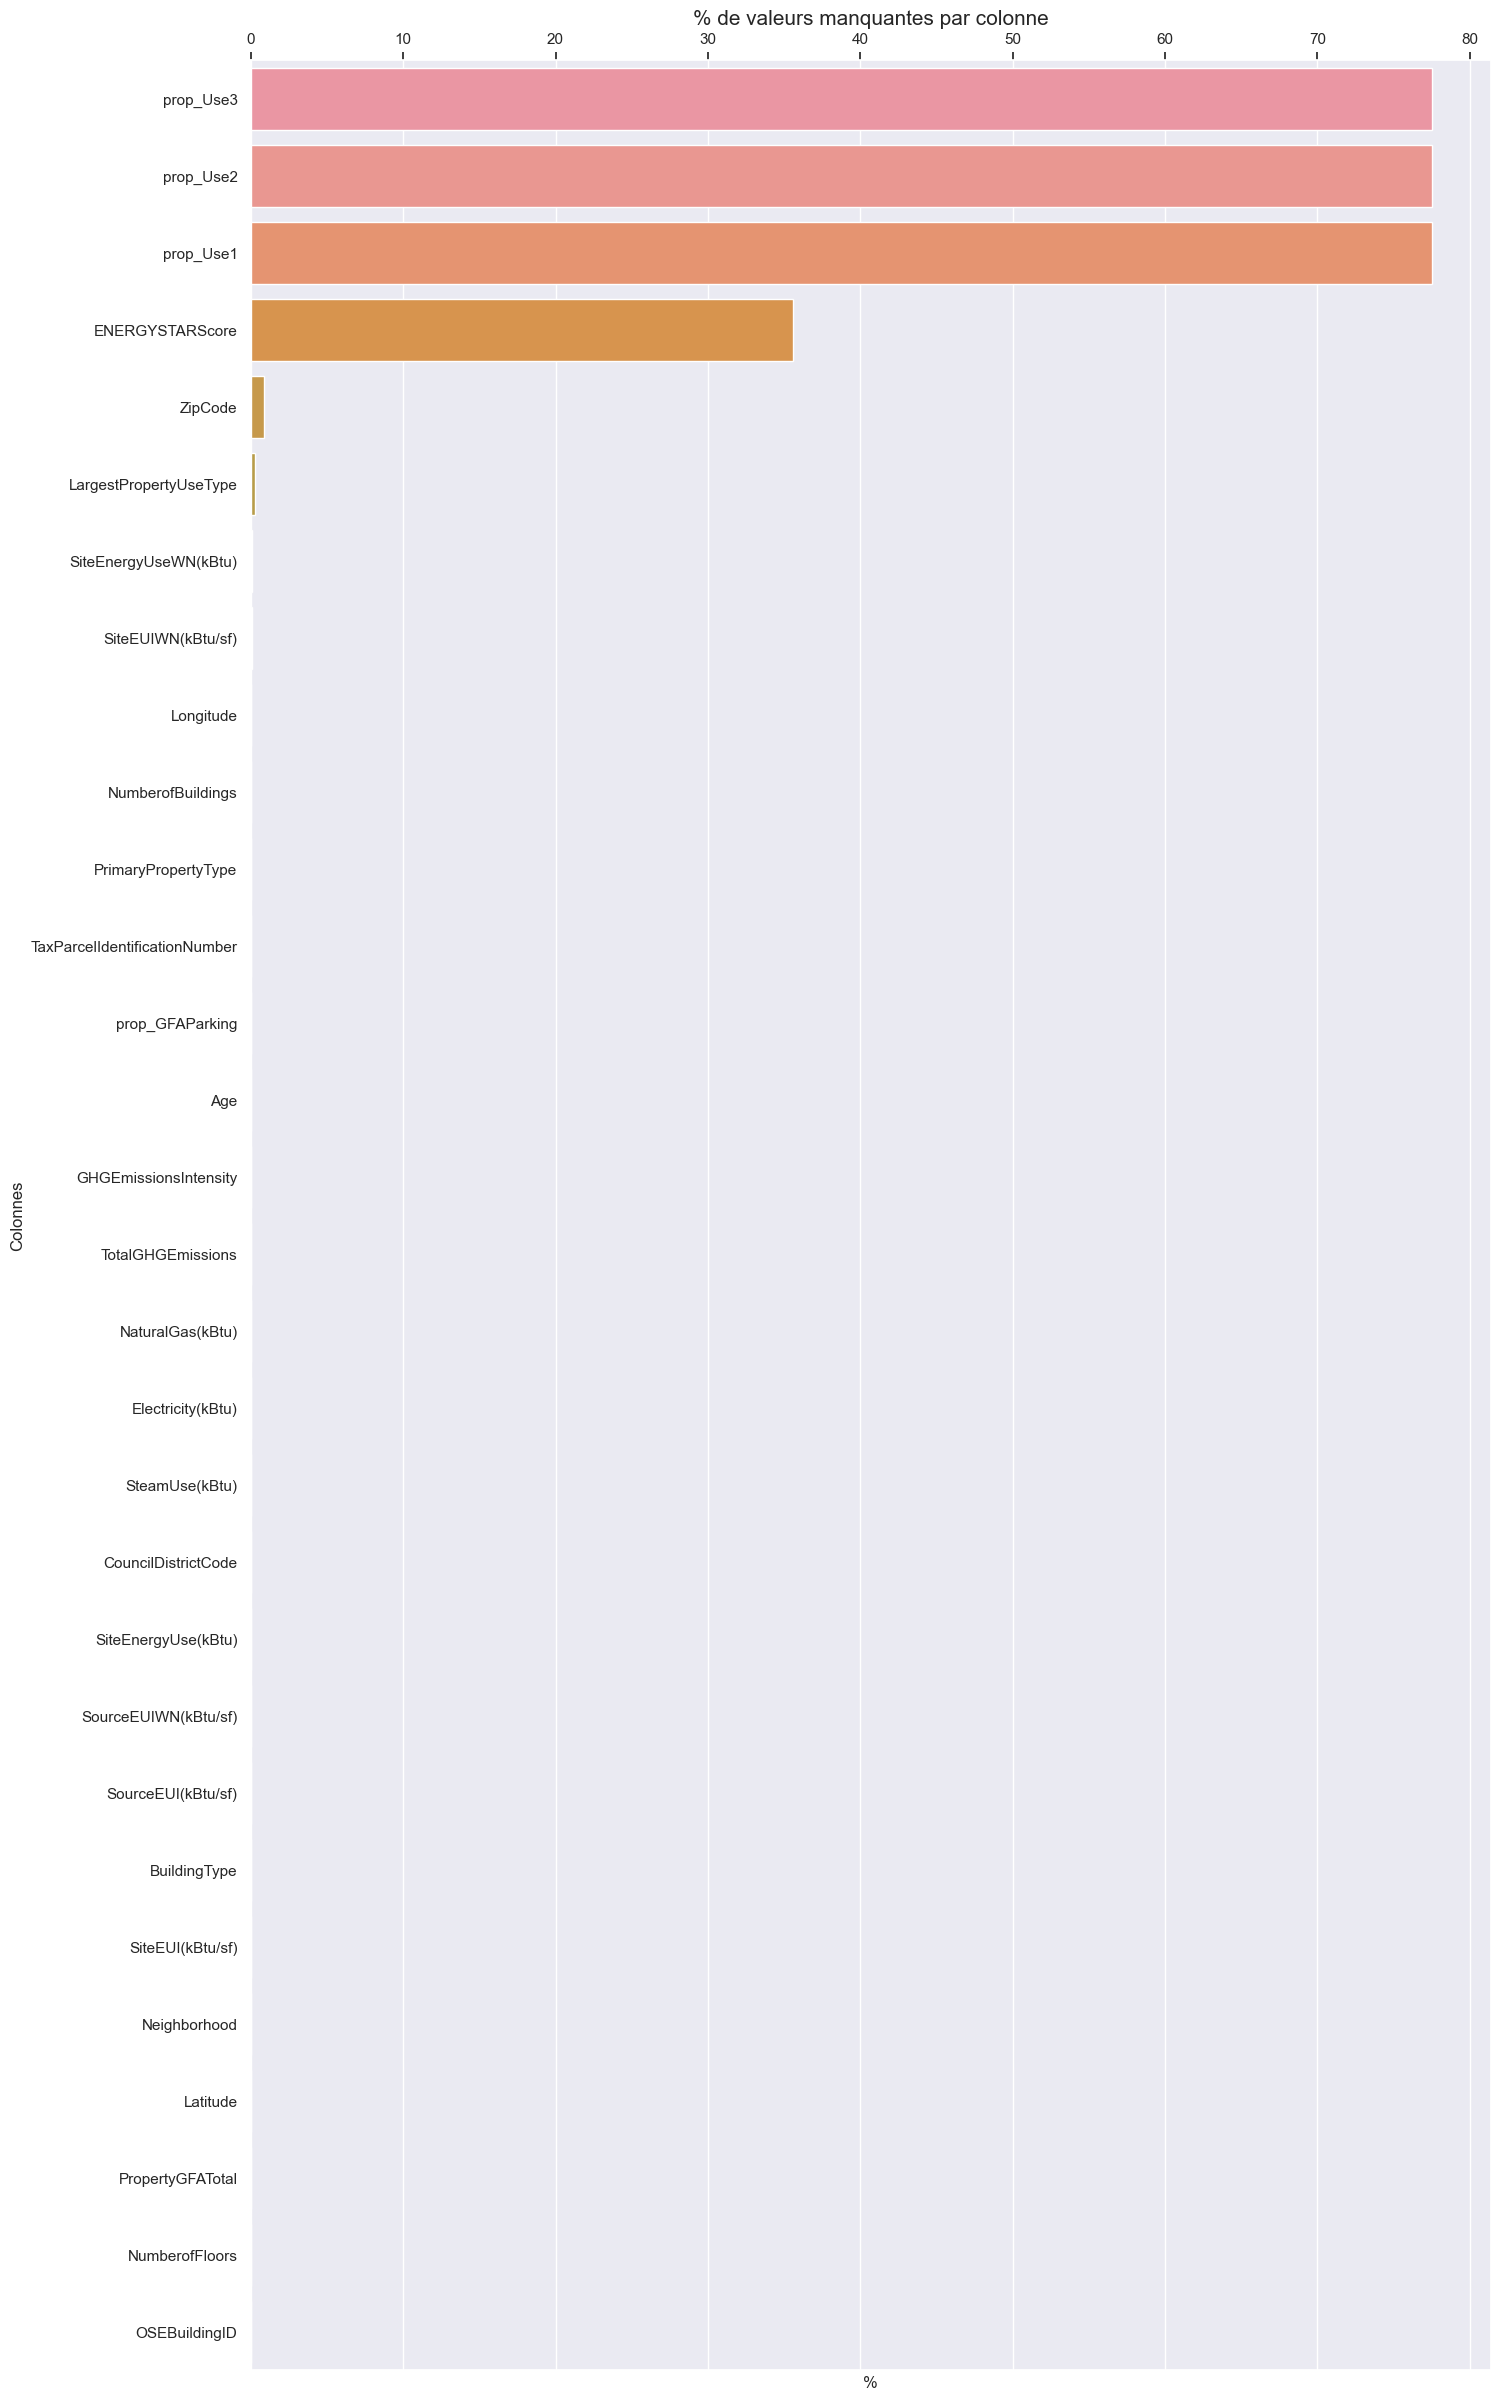

In [35]:
null_col_graph(dfdata)

## C. Outliers

In [36]:
cleandata = dfdata.copy()
cleandata.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseType', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Age', 'prop_GFAParking',
       'prop_Use1', 'prop_Use2', 'prop_Use3'],
      dtype='object')

In [37]:
# Imputation de 0 dans les colonnes 'prop_Use'
cols_to_impute = ['prop_Use1',
                  'prop_Use2',
                  'prop_Use3'
                 ]

cleandata[cols_to_impute] = cleandata[cols_to_impute].fillna(0)
cleandata

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,...,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
0,1,NonResidential,Hotel,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1.0,...,2003882.00,3.946027e+06,1.276453e+06,249.98,2.83,89,0.000000,0.000000,0.000000,0.000000
1,2,NonResidential,Hotel,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1.0,...,0.00,3.242851e+06,5.145082e+06,295.86,2.86,20,0.145453,0.809918,0.145453,0.044629
2,3,NonResidential,Hotel,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1.0,...,21566554.00,4.952666e+07,1.493800e+06,2089.28,2.19,47,0.205748,0.000000,0.000000,0.000000
3,5,NonResidential,Hotel,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1.0,...,2214446.25,2.768924e+06,1.811213e+06,286.43,4.67,90,0.000000,0.000000,0.000000,0.000000
4,8,NonResidential,Hotel,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1.0,...,0.00,5.368607e+06,8.803998e+06,505.01,2.88,36,0.353115,0.644776,0.355224,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,50221,Nonresidential COS,Other,NaN,2524039059,1,DELRIDGE NEIGHBORHOODS,47.54067,-122.37441,1.0,...,0.00,6.323620e+05,2.997200e+05,20.33,1.11,34,0.000000,0.000000,0.000000,0.000000
3372,50223,Nonresidential COS,Other,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,1.0,...,0.00,3.965461e+05,5.537300e+05,32.17,2.01,12,0.000000,0.000000,0.000000,0.000000
3373,50224,Nonresidential COS,Other,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1.0,...,0.00,1.792159e+06,3.973739e+06,223.54,16.99,42,0.000000,0.576347,0.423653,0.000000
3374,50225,Nonresidential COS,Mixed Use Property,NaN,7883603155,1,GREATER DUWAMISH,47.52832,-122.32431,1.0,...,0.00,3.488702e+05,3.706010e+05,22.11,1.57,27,0.000000,0.485868,0.478507,0.035625


In [38]:
# Supression des lignes avec valeurs nulles dans 'ZipCode' et 'LargestPropertyUseType'
cleandata.dropna(subset=['ZipCode', 'LargestPropertyUseType'], axis=0, inplace=True)

#### Définition des catégories de colonnes

In [39]:
features = ['PropertyGFATotal',
            'ENERGYSTARScore',
            'SiteEUI(kBtu/sf)',
            'SourceEUI(kBtu/sf)',
            'SiteEnergyUse(kBtu)',
            'SteamUse(kBtu)',
            'Electricity(kBtu)',
            'NaturalGas(kBtu)',
            'TotalGHGEmissions',
            'GHGEmissionsIntensity',
            'Age',
            'ZipCode',
            'TaxParcelIdentificationNumber',
            'CouncilDistrictCode',
            'NumberofBuildings',
            'NumberofFloors',
            'SiteEUIWN(kBtu/sf)',
            'SourceEUIWN(kBtu/sf)',
            'SiteEnergyUseWN(kBtu)',
            'BuildingType',
            'PrimaryPropertyType',
            'Neighborhood',
            'LargestPropertyUseType',
            'Latitude',
            'Longitude',
            'OSEBuildingID'
            ]


quant_features = ['PropertyGFATotal',
                  'ENERGYSTARScore',
                  'SiteEUI(kBtu/sf)',
                  'SourceEUI(kBtu/sf)',
                  'SiteEnergyUse(kBtu)',
                  'SteamUse(kBtu)',
                  'Electricity(kBtu)',
                  'NaturalGas(kBtu)',
                  'TotalGHGEmissions',
                  'GHGEmissionsIntensity',
                  'Age',
                  'NumberofBuildings',
                  'NumberofFloors',
                  'SiteEUIWN(kBtu/sf)',
                  'SourceEUIWN(kBtu/sf)',
                  'SiteEnergyUseWN(kBtu)',
                  'prop_GFAParking',
                  'prop_Use1',
                  'prop_Use2',
                  'prop_Use3'
                 ]

qual_features = ['BuildingType',
                 'PrimaryPropertyType',
                 'Neighborhood',
                 'LargestPropertyUseType'
                ]

targets = ['SiteEnergyUse(kBtu)',
          'TotalGHGEmissions'
          ]

geo_features = ['Latitude',
                'Longitude',
               ]

#### Tableau de contingence des variables qualitatives

In [40]:
cleandata.BuildingType.unique()

array(['NonResidential', 'Nonresidential COS', 'Campus',
       'SPS-District K-12', 'Nonresidential WA'], dtype=object)

In [41]:
dfcont = pd.crosstab(cleandata.BuildingType, [cleandata.Neighborhood])
dfcont.style.applymap(colors)

Neighborhood,BALLARD,Ballard,CENTRAL,Central,DELRIDGE,DOWNTOWN,Delridge,EAST,GREATER DUWAMISH,LAKE UNION,MAGNOLIA / QUEEN ANNE,NORTH,NORTHEAST,NORTHWEST,North,Northwest,SOUTHEAST,SOUTHWEST
BuildingType,,,,,,,,,,,,,,,,,,
Campus,0,0,2,0,2,5,0,2,6,1,2,0,2,1,0,0,0,0
NonResidential,51,4,36,4,30,329,4,110,303,138,124,43,112,66,8,4,26,31
Nonresidential COS,2,1,2,0,3,13,0,3,13,2,14,4,2,5,0,0,4,0
Nonresidential WA,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
SPS-District K-12,1,0,0,0,1,0,0,0,1,0,2,2,0,2,0,0,1,0


#### Suppression des valeurs strictement négatives sur les variables quantitatives

In [42]:
del_neg(quant_features, cleandata)

Outliers de la variable Electricity(kBtu)


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,...,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
3206,49784,NonResidential,Small- and Mid-Sized Office,98122.0,7234600195,3,CENTRAL,47.61432,-122.31257,1.0,...,0.0,-115417.0,0.0,-0.8,-0.02,3,0.0,0.0,0.0,0.0


(1524, 30)

#### Suppression des valeurs inférieures ou égales à 0 sur les targets

In [43]:
del_neg_equal(targets, cleandata)

Outliers de la variable TotalGHGEmissions


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,...,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
513,700,NonResidential,Supermarket / Grocery Store,98119.0,7666201460,7,MAGNOLIA / QUEEN ANNE,47.63718,-122.37734,1.0,...,0.0,0.0,0.0,0.0,0.0,8,0.0,0.658333,0.25,0.091667


(1523, 30)

#### Analyse des doublons sur OSEBuildingID

In [44]:
cleandata['OSEBuildingID'].value_counts()

1        1
23671    1
23716    1
23712    1
23711    1
        ..
761      1
760      1
759      1
758      1
50101    1
Name: OSEBuildingID, Length: 1523, dtype: int64

Il n'y a pas de doublons sur la variables 'OSEBuildingID'

#### Targets : Boxplots

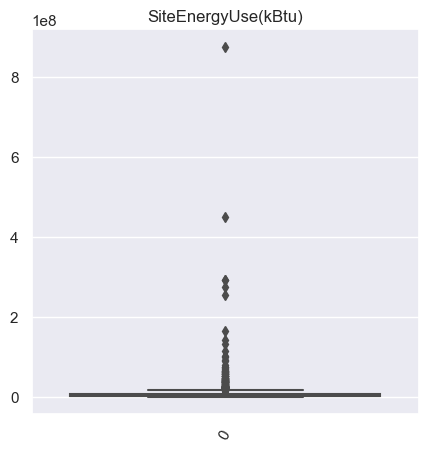

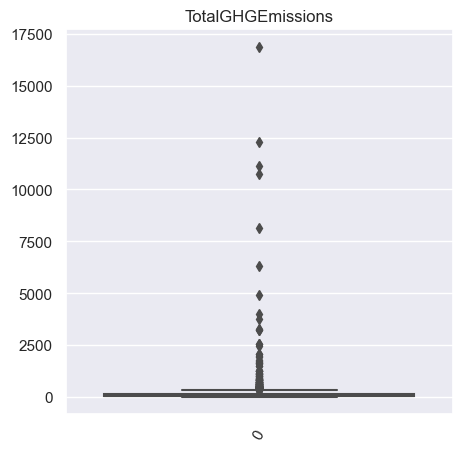

In [45]:
#Analyse de la distribution des targets
for x in targets:
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes()
    plt.xticks(rotation=60)
    sns.boxplot(data=dfdata[x]).set_title(x)

#### Targets : Méthode des Ecarts Inter Quartiles (IQR)

In [46]:
outliers_IQR(targets, cleandata)

Lower bound : -8005378.875
Upper bound : 16708286.125
SiteEnergyUse(kBtu) : 169 outliers
-------------
Lower bound : -169.90249999999997
Upper bound : 338.3975
TotalGHGEmissions : 167 outliers
-------------


Le fichier d'analyse n'étant plus constitué que de 1523 lignes, nous conserverons l'ensemble de l'information restante afin de ne pas risquer un underfitting pour la modélisation.

# 3. Analyse exploratoire

## A. Analyse univariée

### Analyse des targets

TARGET : SiteEnergyUse(kBtu)
INFOS : 
	mean: 8961966.2895
	med: 2737534.5
	mod: 57133.1992
	var: 994724726879437.8
	std: 31539256.917
	skew: 17.3442
	kur: 409.9467


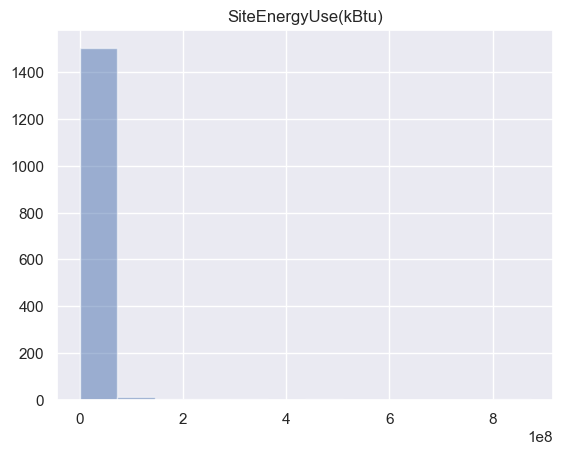

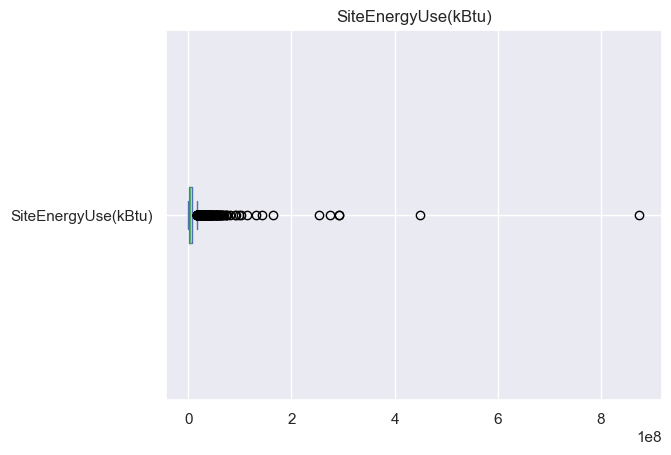

TARGET : TotalGHGEmissions
INFOS : 
	mean: 195.852
	med: 50.55
	mod: 6.3
	var: 616170.2966
	std: 784.9652
	skew: 13.6172
	kur: 226.4425


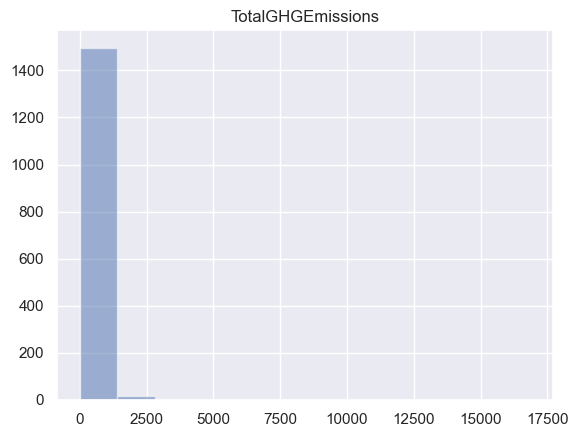

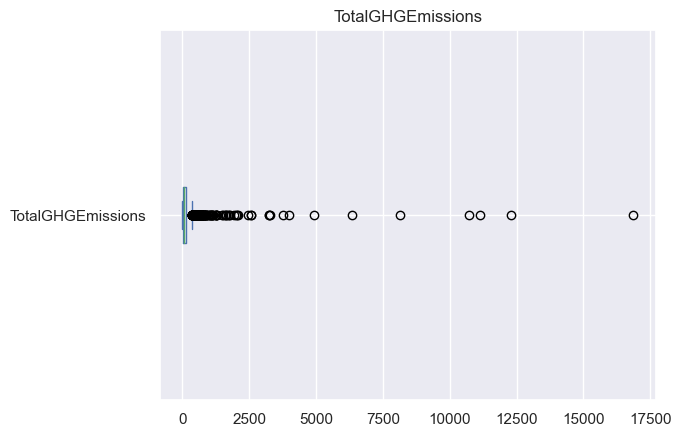

In [47]:
feature_distrib(cleandata, targets)

### Analyse des variables qualitatives

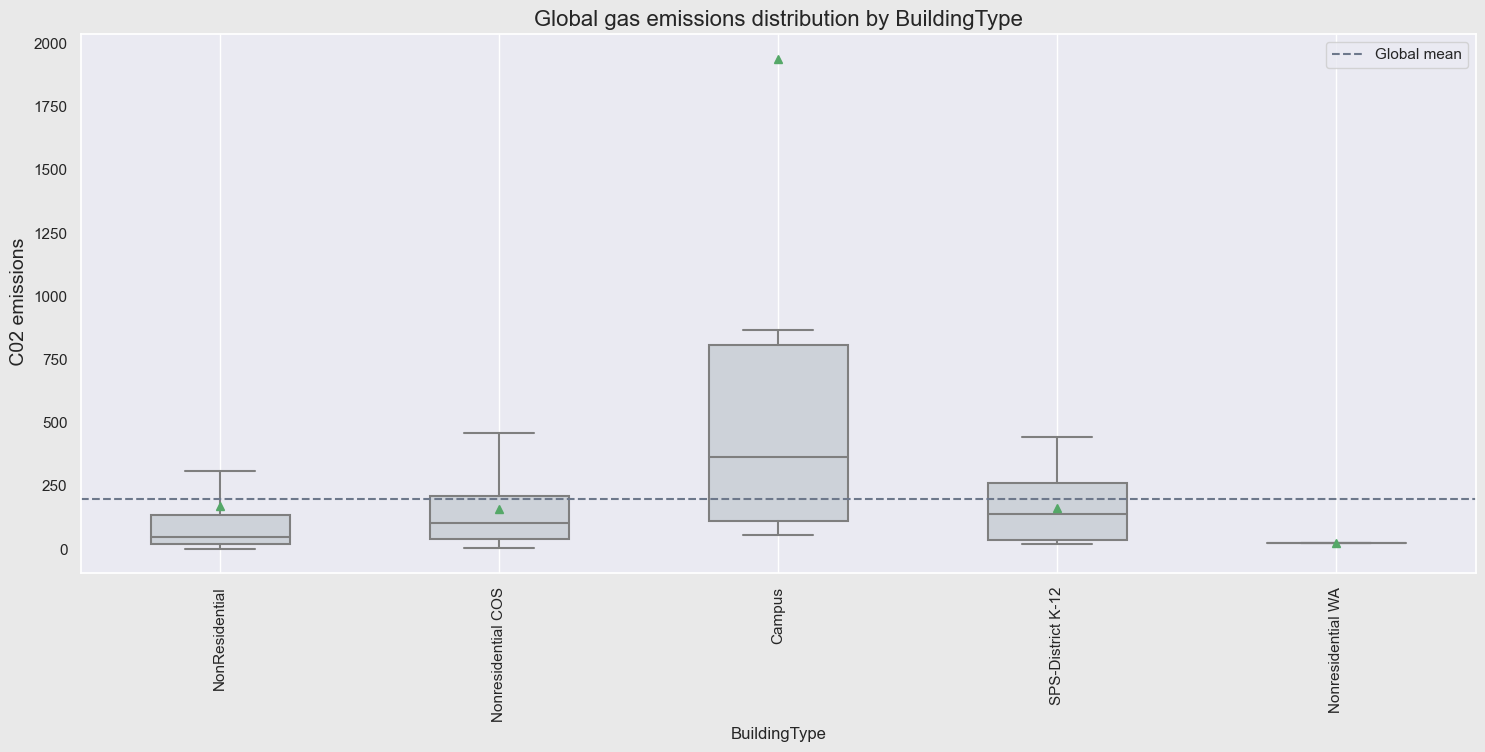

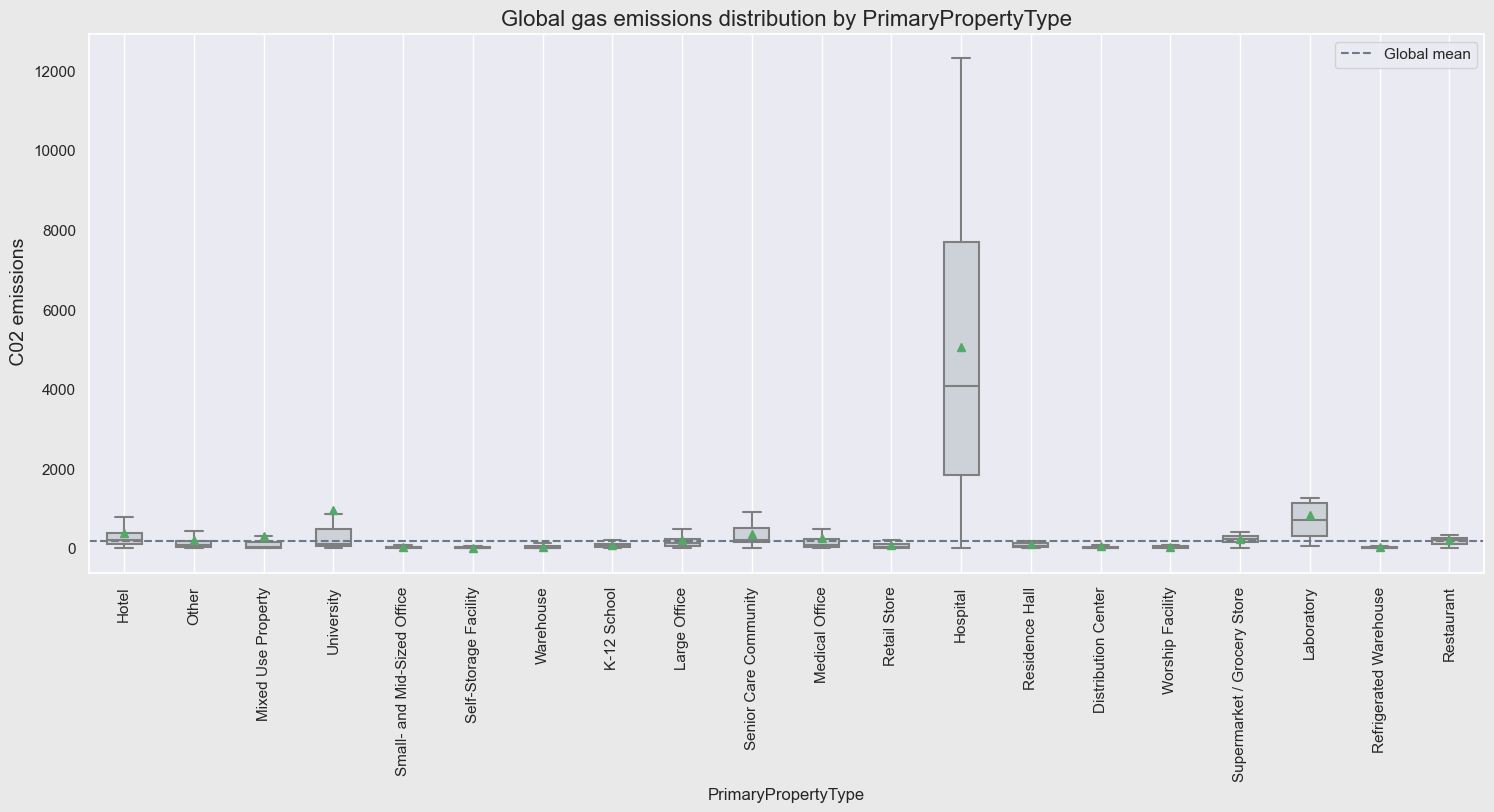

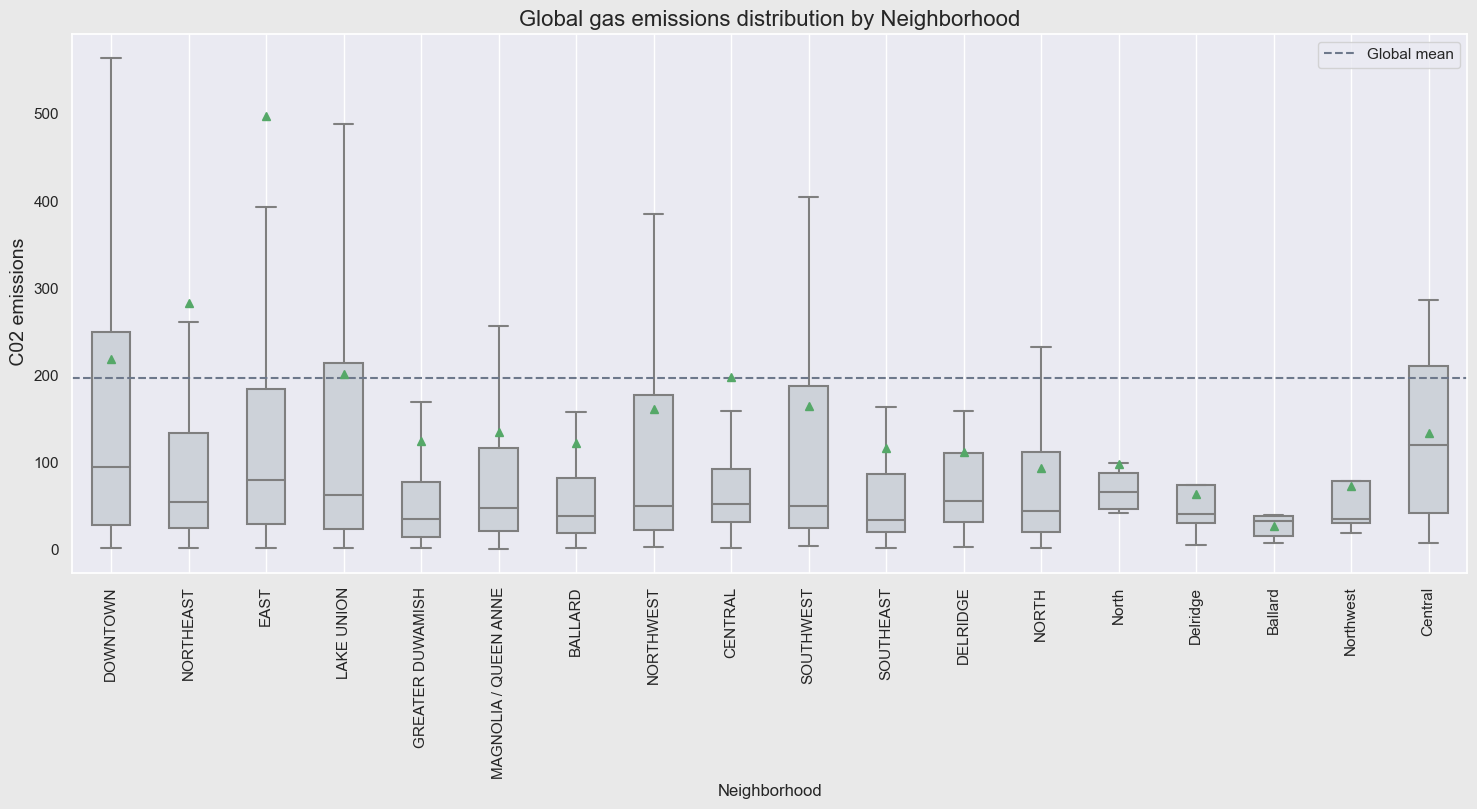

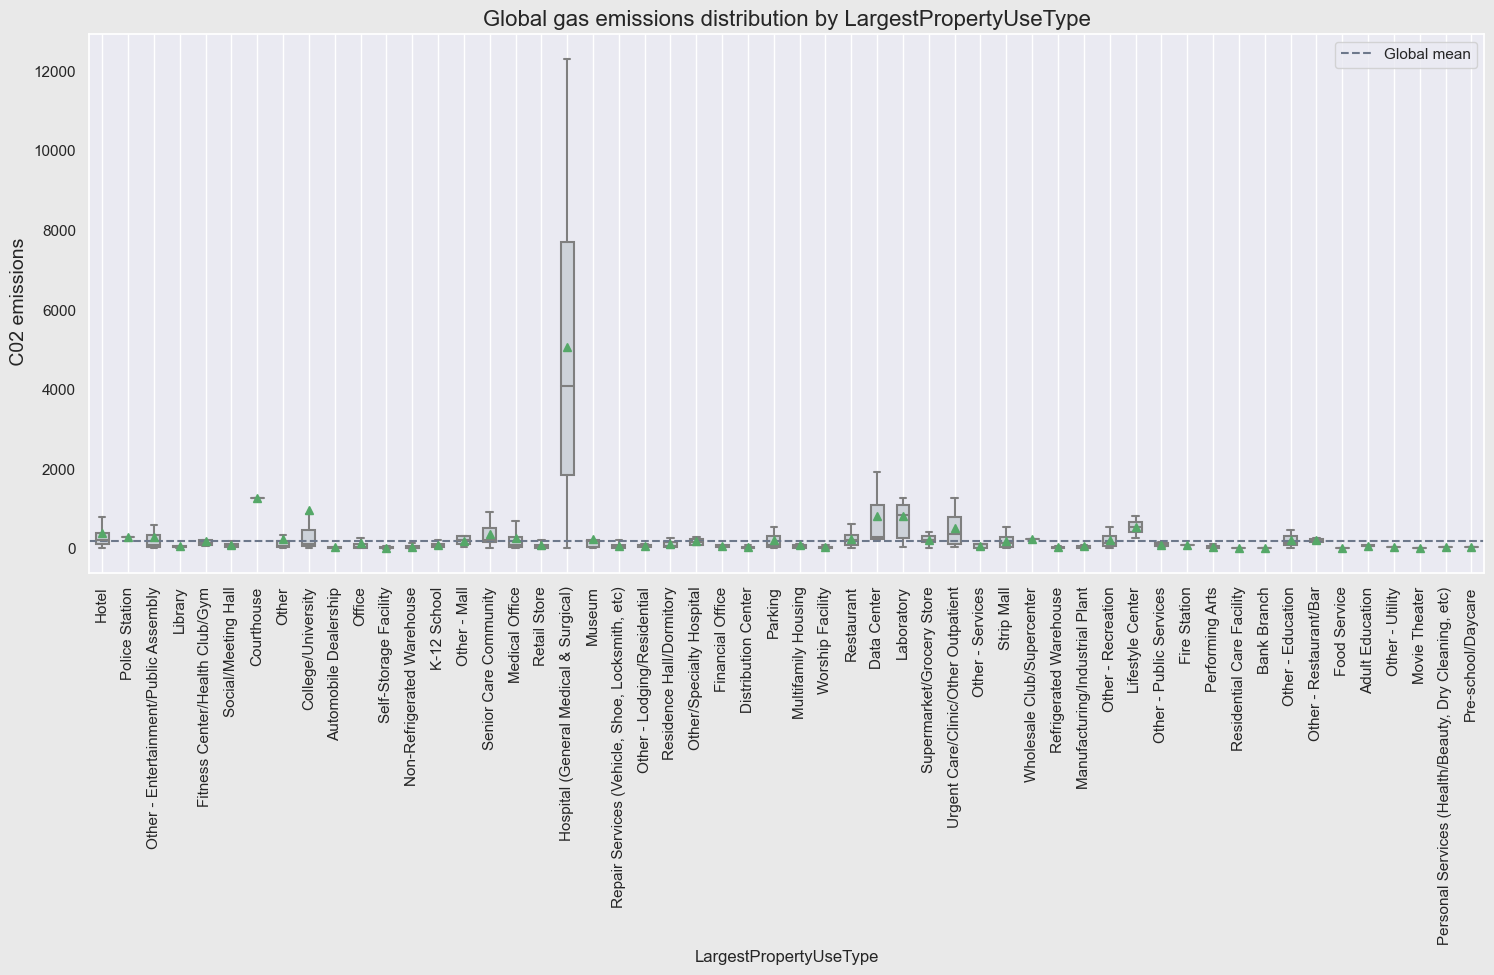

In [48]:
# Analyse des émissions de CO2
for x in qual_features:
    boxplotsCO2(x, cleandata)

#### Commentaires :  
  
  On remarque que certains types de bâtiments sont de plus gros émetteurs de gaz à effet de serre, notamment les hopitaux, universités, data center et laboratoires.  
  Cependant, il semble que le quartier n'ait pas d'incidence sur la quantité de gaz émise.

### Analyse des variables quantitatives

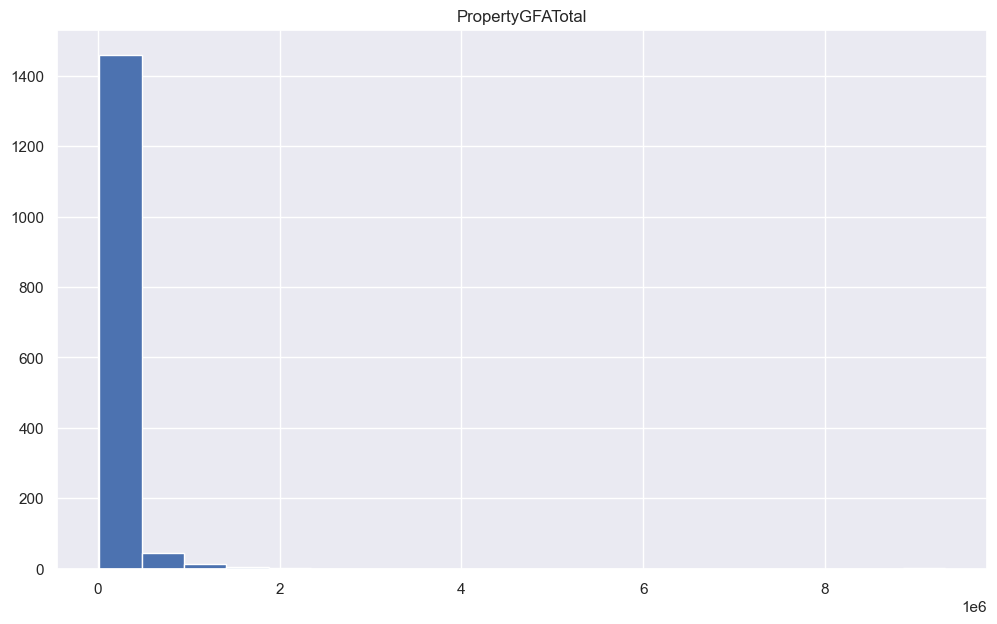

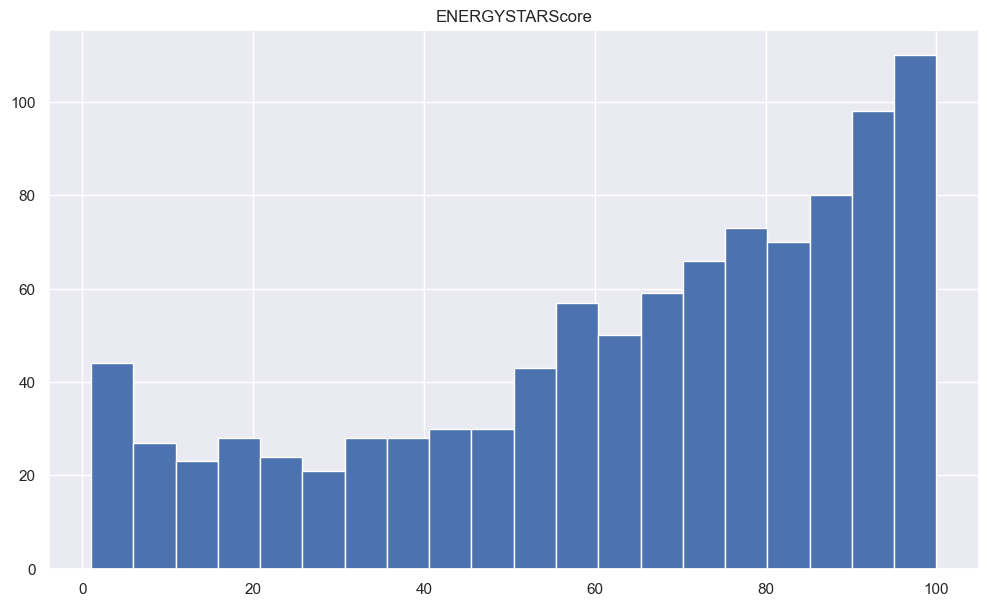

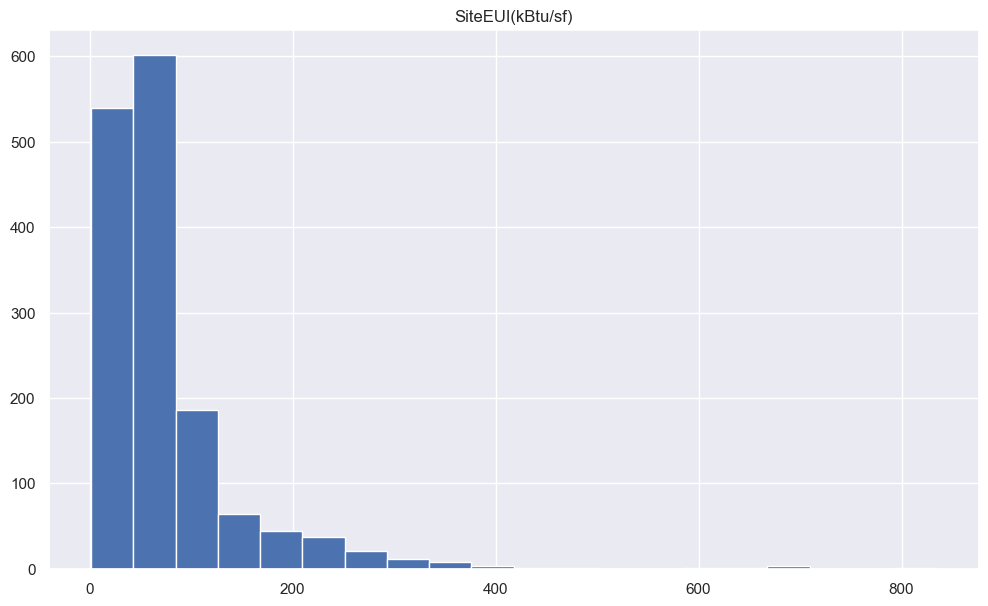

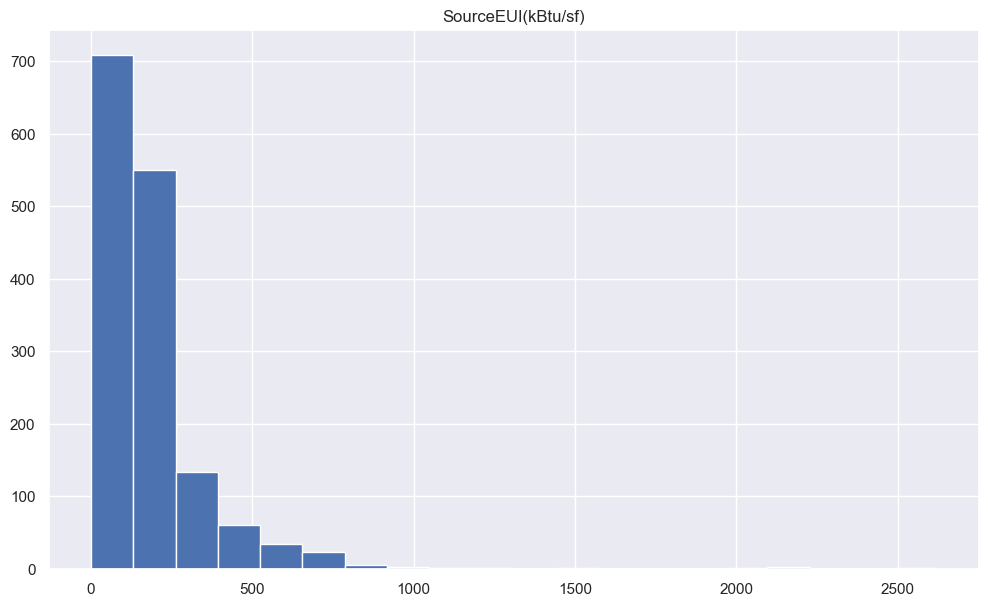

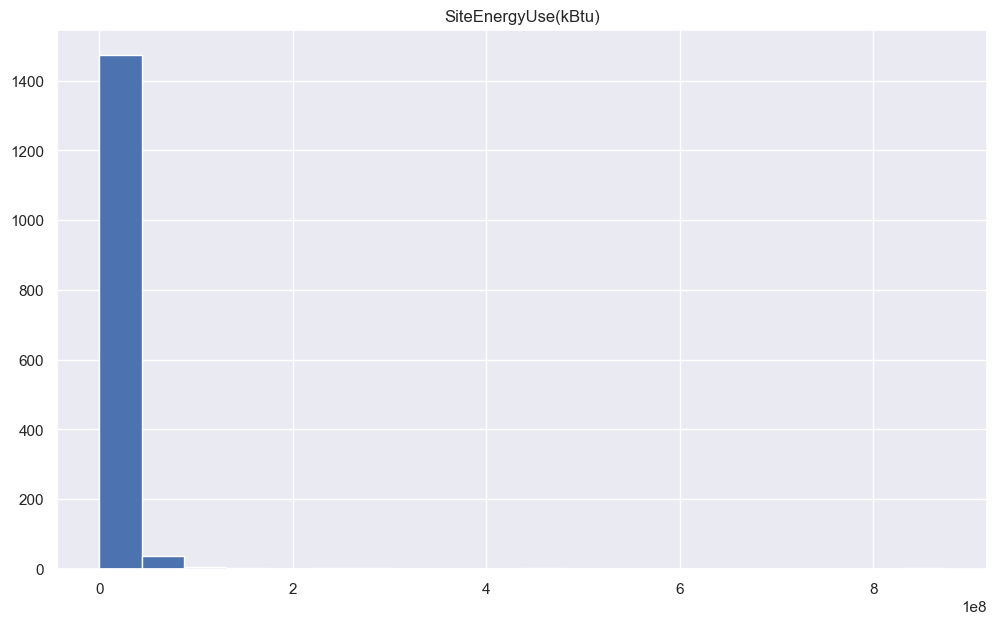

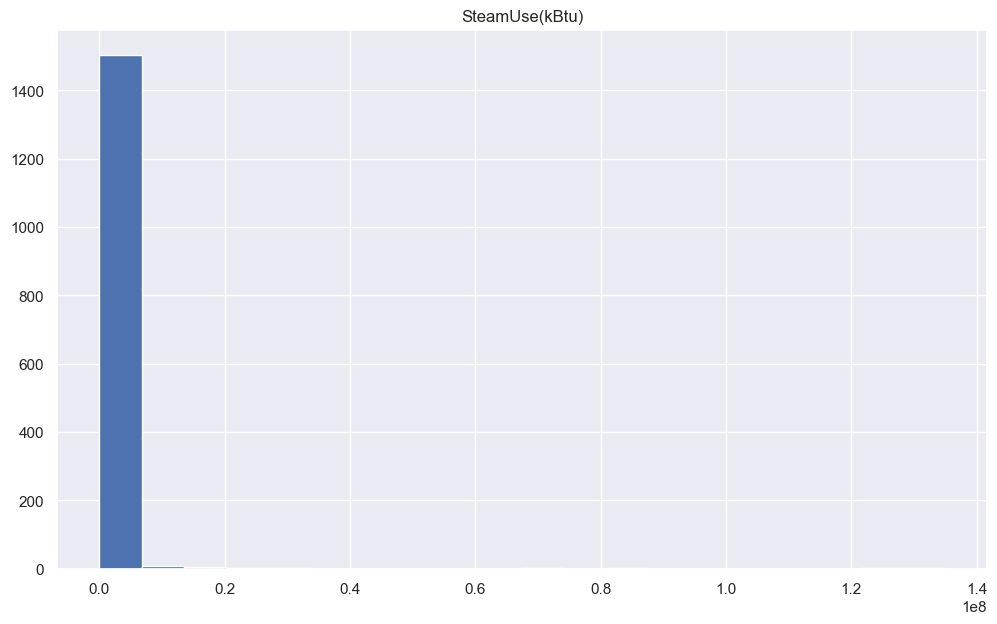

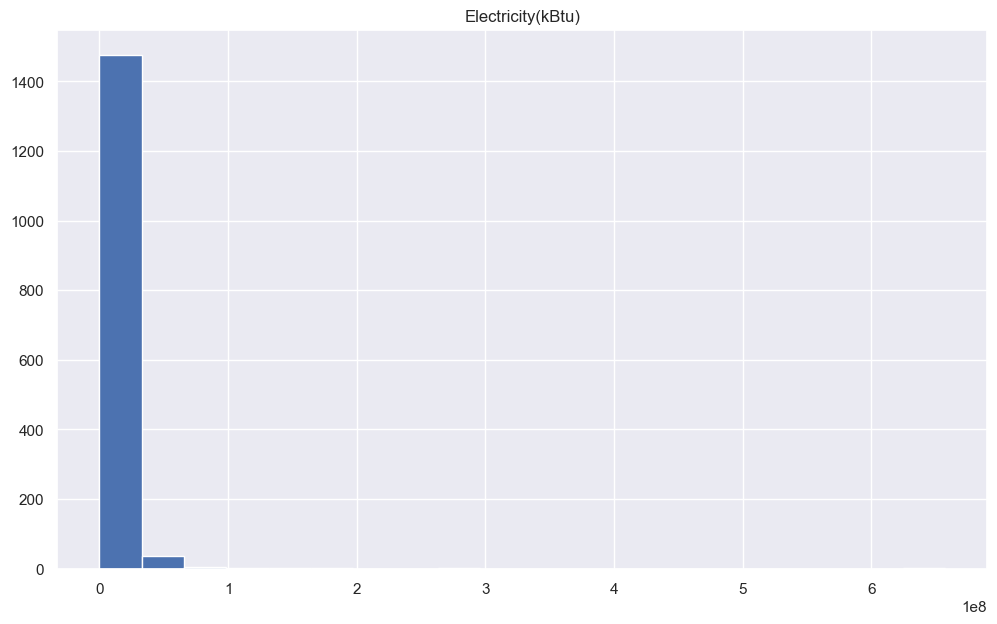

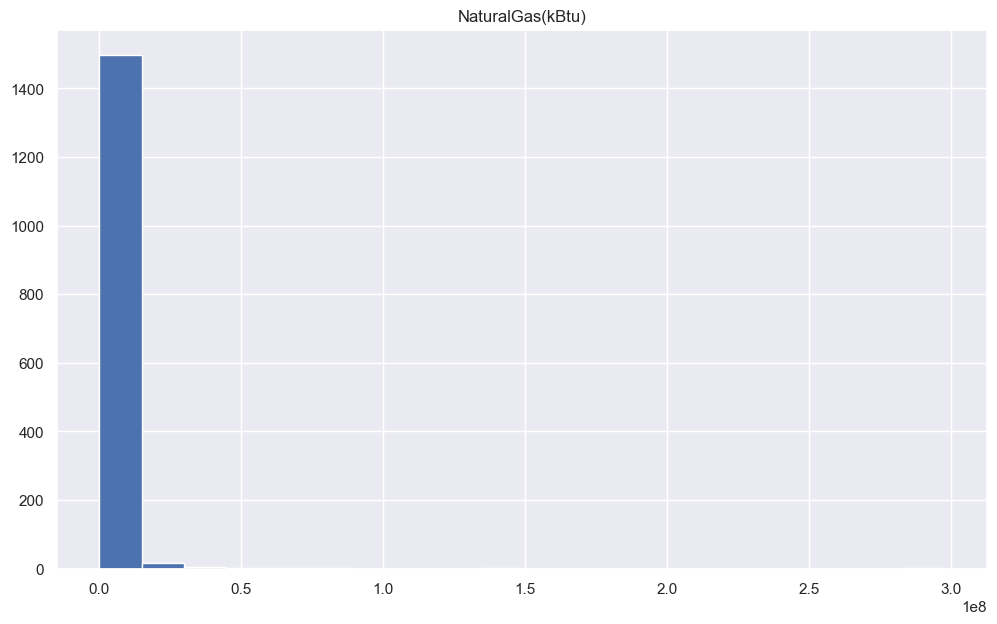

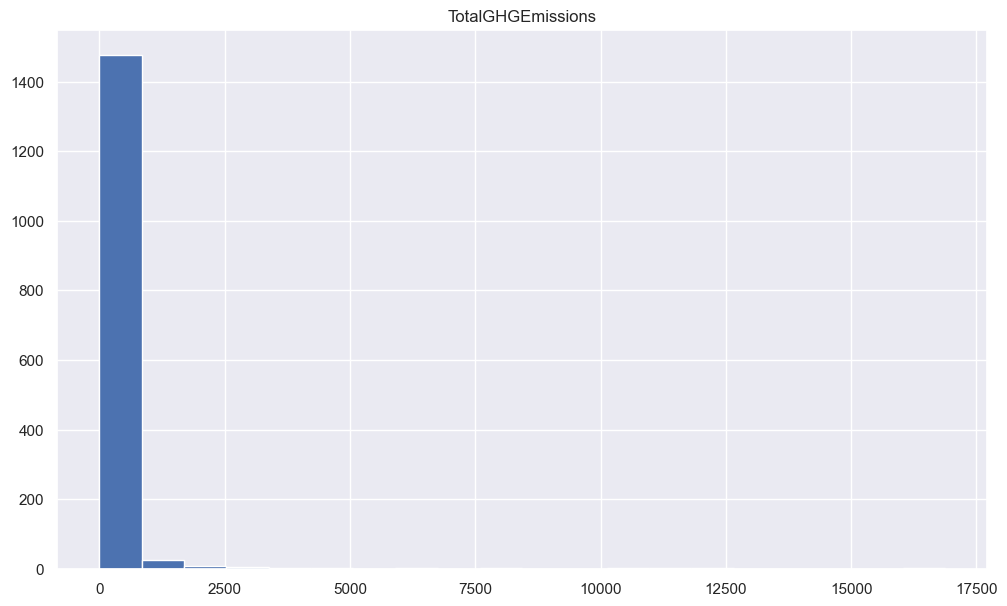

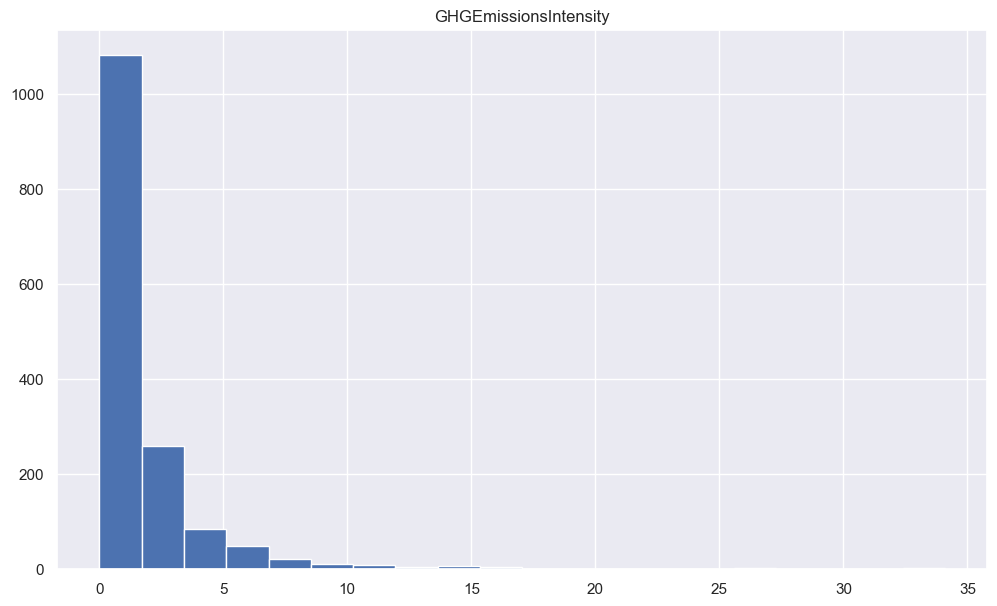

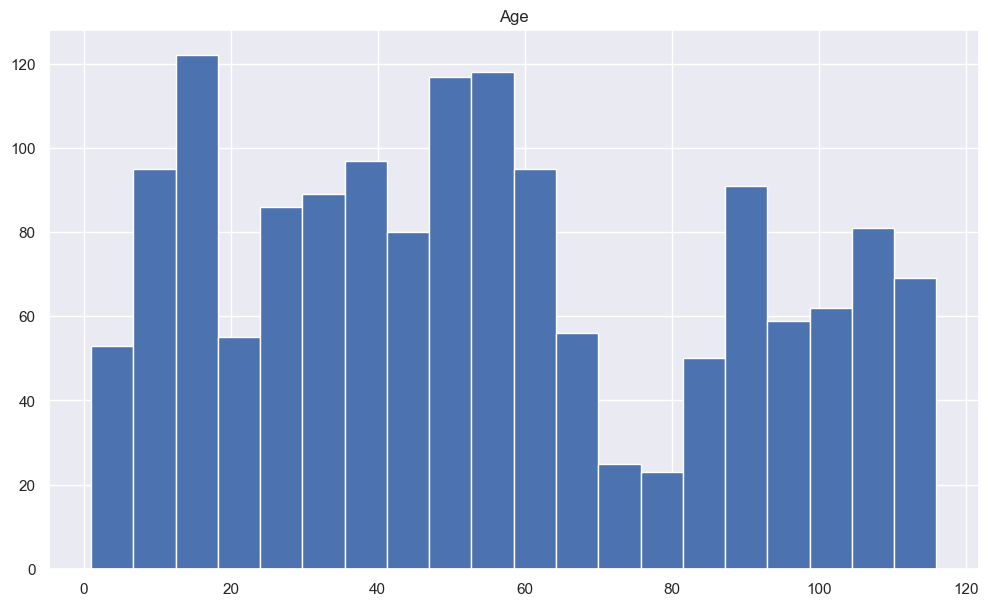

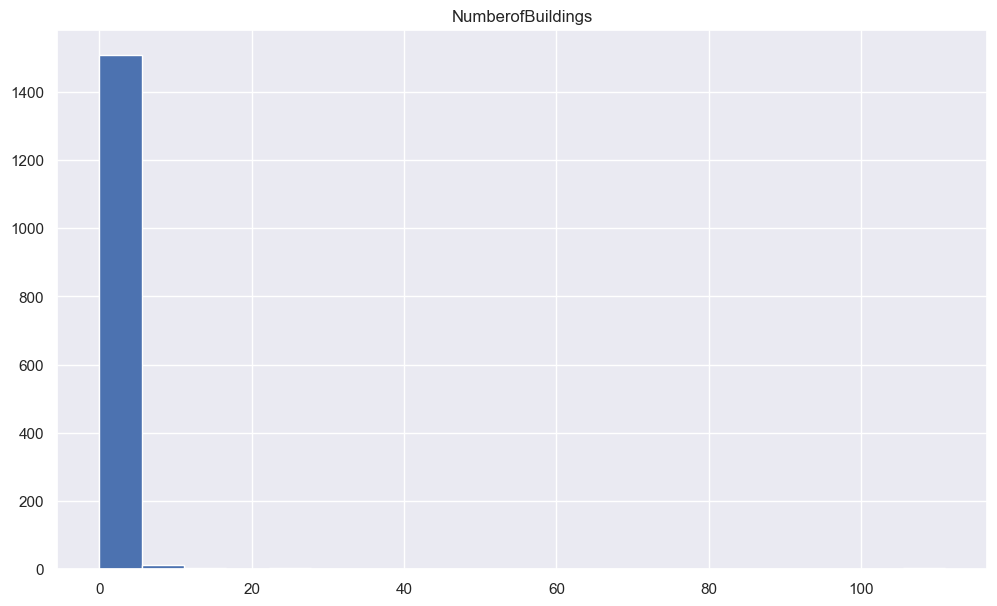

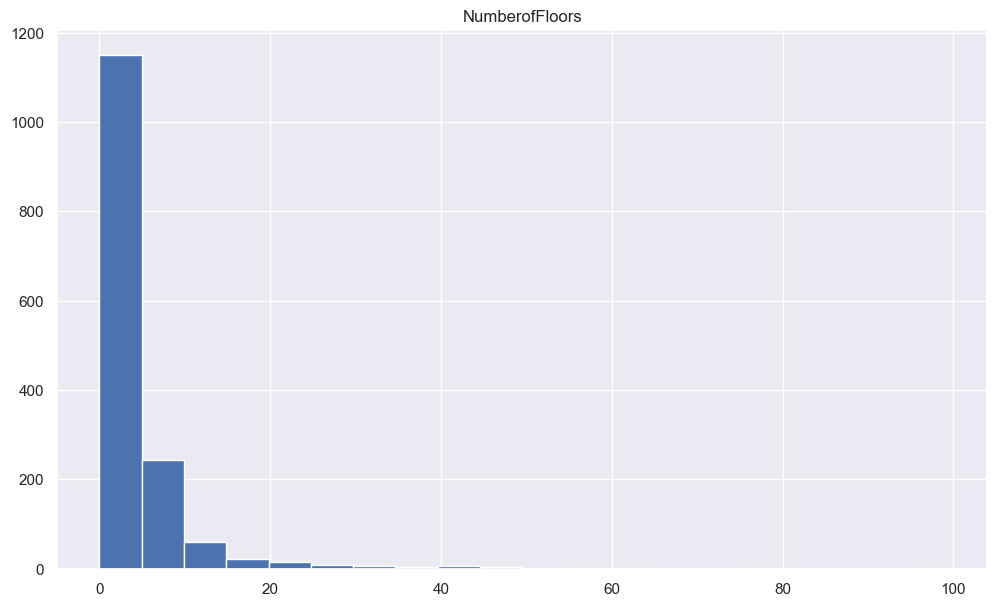

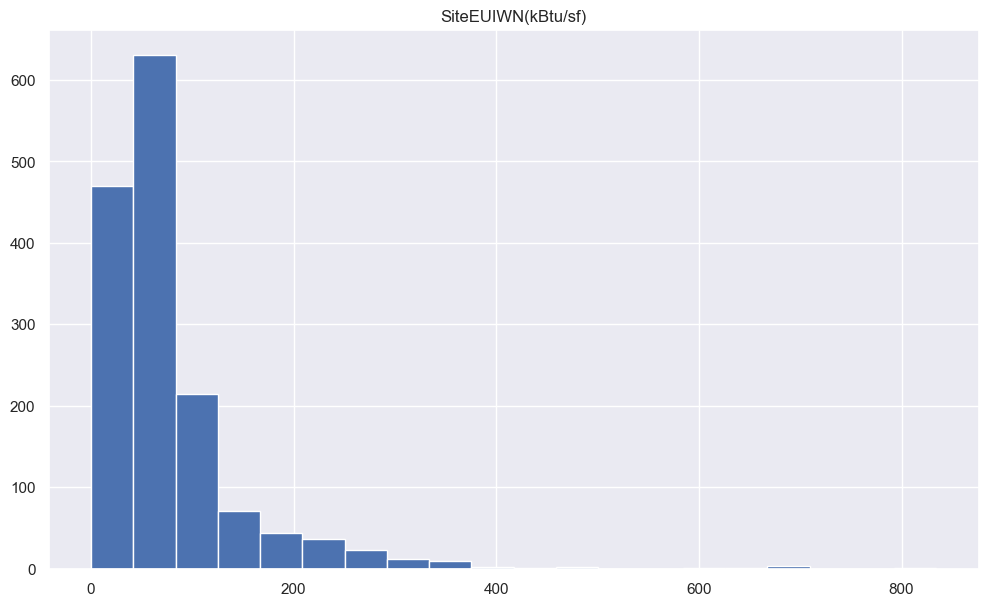

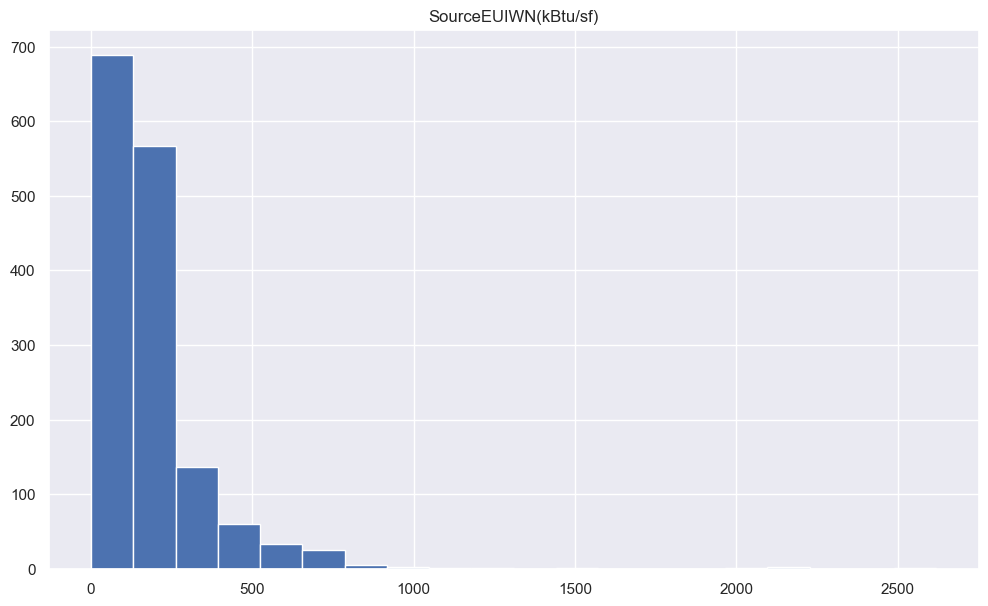

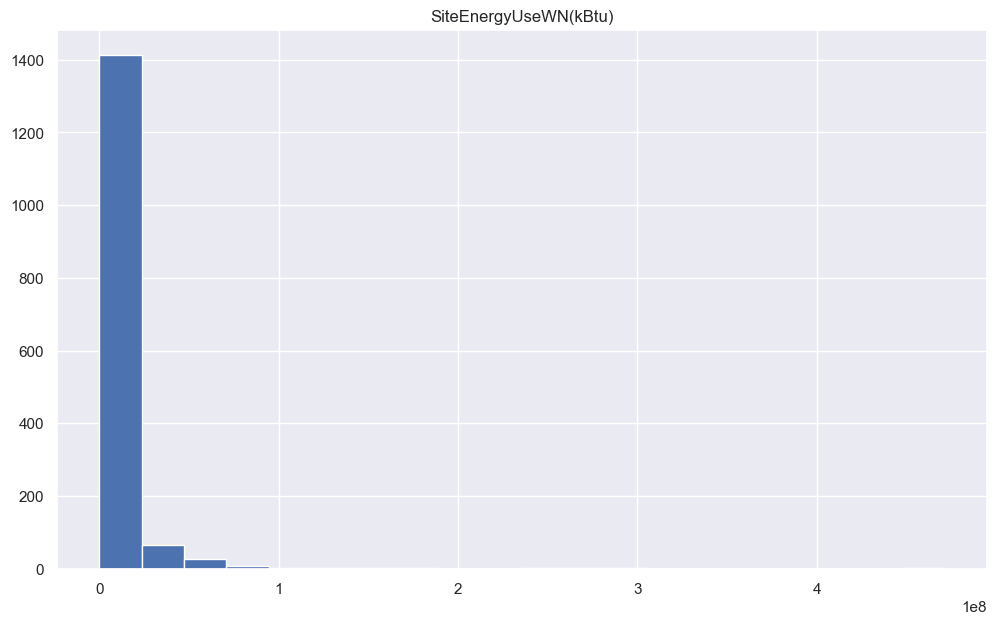

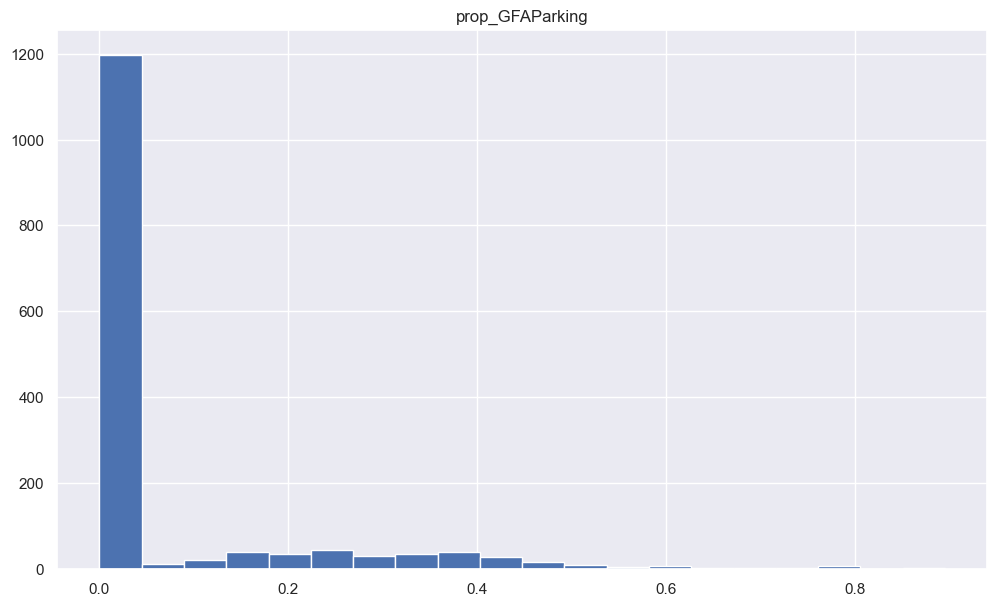

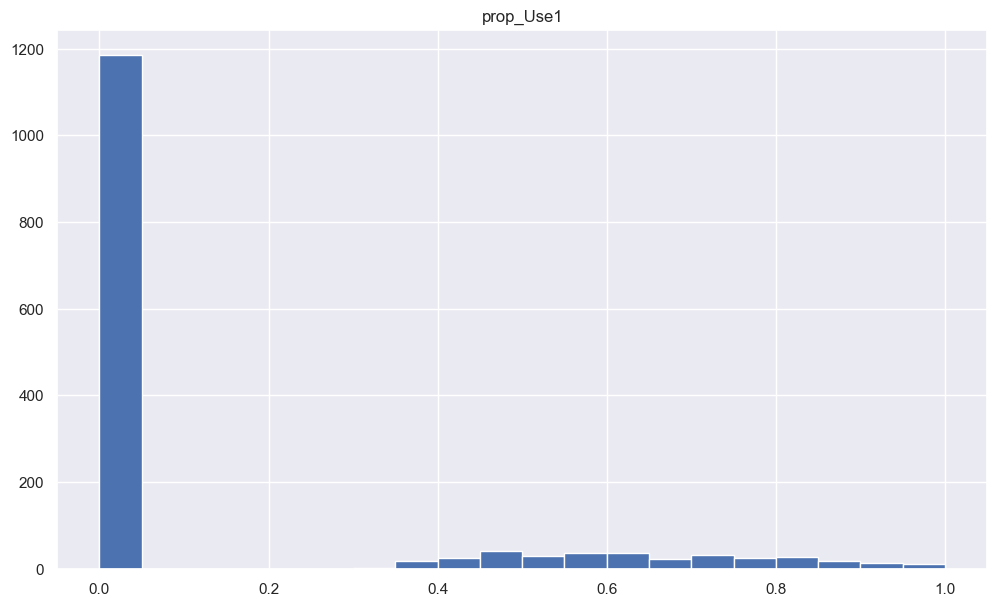

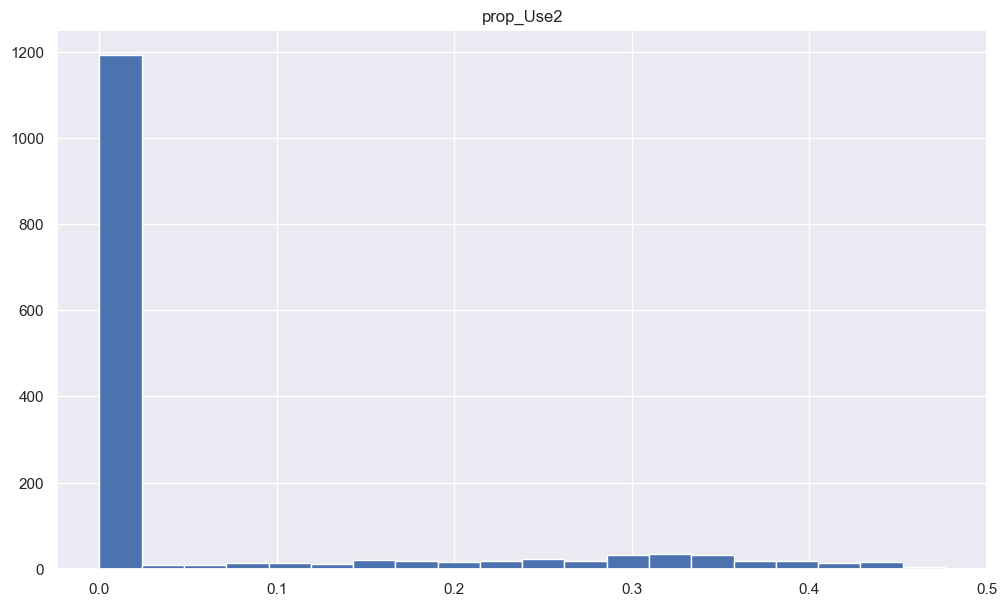

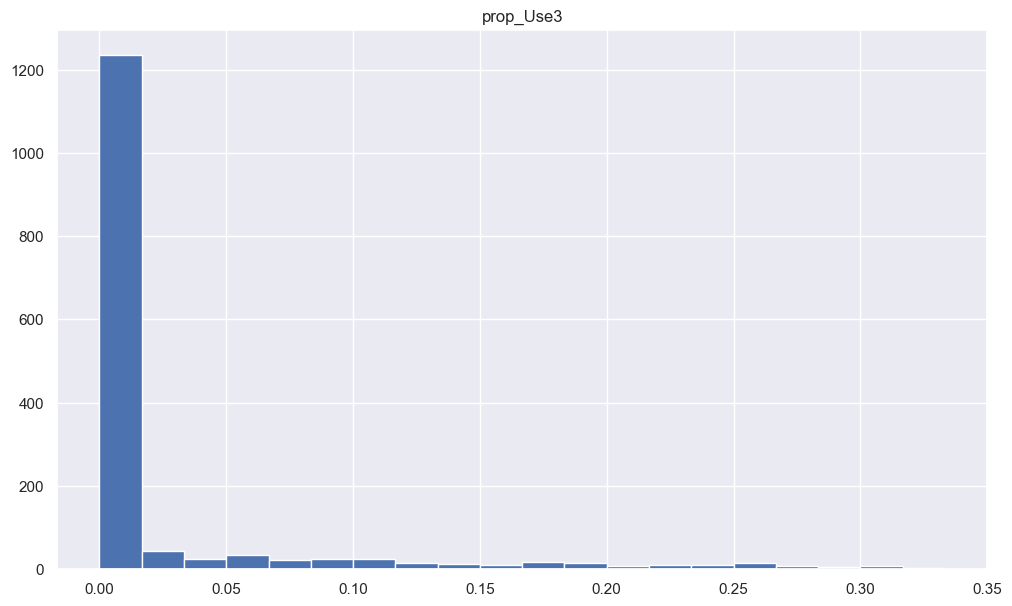

In [49]:
feature_analysis(cleandata, quant_features)

## B. Analyse multivariée

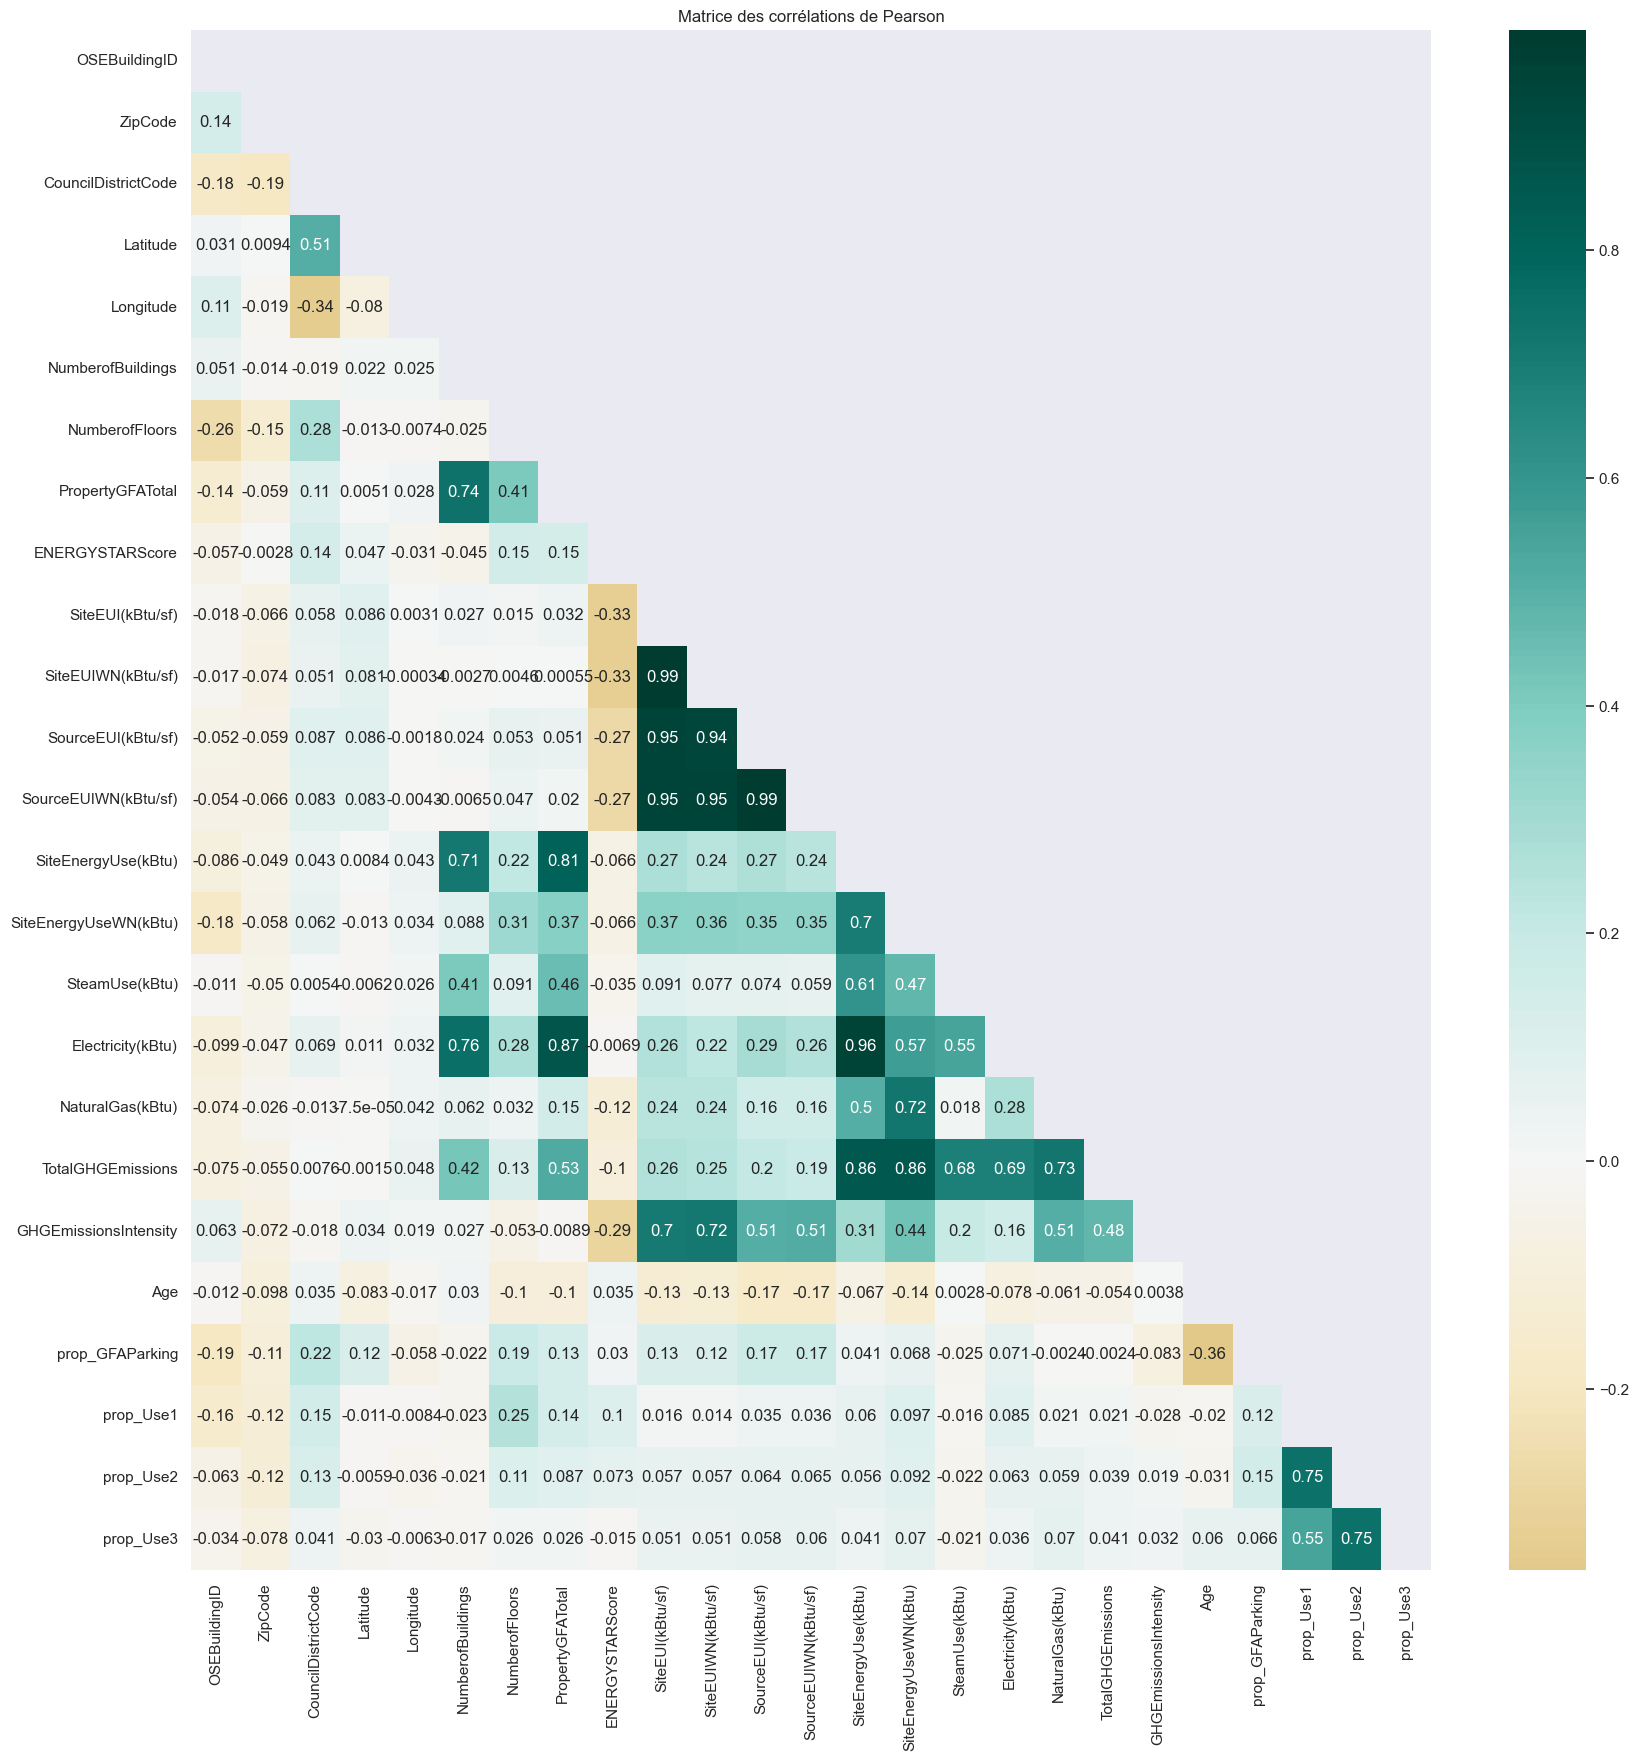

In [50]:
# Matrice des corrélations
corr_analysis(cleandata)

Nous supprimerons l'ensemble des variables relatives aux relevés, afin de ne conserver que les paramètres propres aux bâtiments, qui nous permettrons de modéliser la consommation et les émissions.

In [51]:
# Supprimons les variables ayant de trop fortes corrélations (> 0.8), hors targets
cleandata.drop(['OSEBuildingID',
                'SiteEUI(kBtu/sf)',
                'SiteEUIWN(kBtu/sf)',
                'SourceEUI(kBtu/sf)',
                'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUseWN(kBtu)',
                'SteamUse(kBtu)',
                'Electricity(kBtu)',
                'NaturalGas(kBtu)',
                'GHGEmissionsIntensity'
               ],axis=1, inplace=True)
cleandata

,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
0,NonResidential,Hotel,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1.0,12,88434,Hotel,60.0,7226362.50,249.98,89,0.000000,0.000000,0.000000,0.000000
1,NonResidential,Hotel,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1.0,11,103566,Hotel,61.0,8387933.00,295.86,20,0.145453,0.809918,0.145453,0.044629
2,NonResidential,Hotel,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1.0,41,956110,Hotel,43.0,72587024.00,2089.28,47,0.205748,0.000000,0.000000,0.000000
3,NonResidential,Hotel,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1.0,10,61320,Hotel,56.0,6794584.00,286.43,90,0.000000,0.000000,0.000000,0.000000
4,NonResidential,Hotel,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1.0,18,175580,Hotel,75.0,14172606.00,505.01,36,0.353115,0.644776,0.355224,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,NonResidential,Small- and Mid-Sized Office,98108.0,2824049007,2,GREATER DUWAMISH,47.53161,-122.29944,1.0,2,24990,Office,9.0,4420650.50,134.80,87,0.000000,0.000000,0.000000,0.000000
3340,NonResidential,Other,98155.0,0225049062,4,NORTHEAST,47.68109,-122.26180,1.0,1,72000,Other - Recreation,NaN,2925780.00,67.65,3,0.000000,0.000000,0.000000,0.000000
3347,NonResidential,K-12 School,98144.0,7548300840,3,GREATER DUWAMISH,47.58831,-122.30650,1.0,3,45000,K-12 School,77.0,1325972.75,9.24,1,0.000000,0.000000,0.000000,0.000000
3356,NonResidential,Mixed Use Property,98109.0,4088803385,7,LAKE UNION,47.62497,-122.33883,1.0,6,345290,Laboratory,NaN,39364116.00,1000.06,1,0.246251,0.443020,0.311377,0.245603


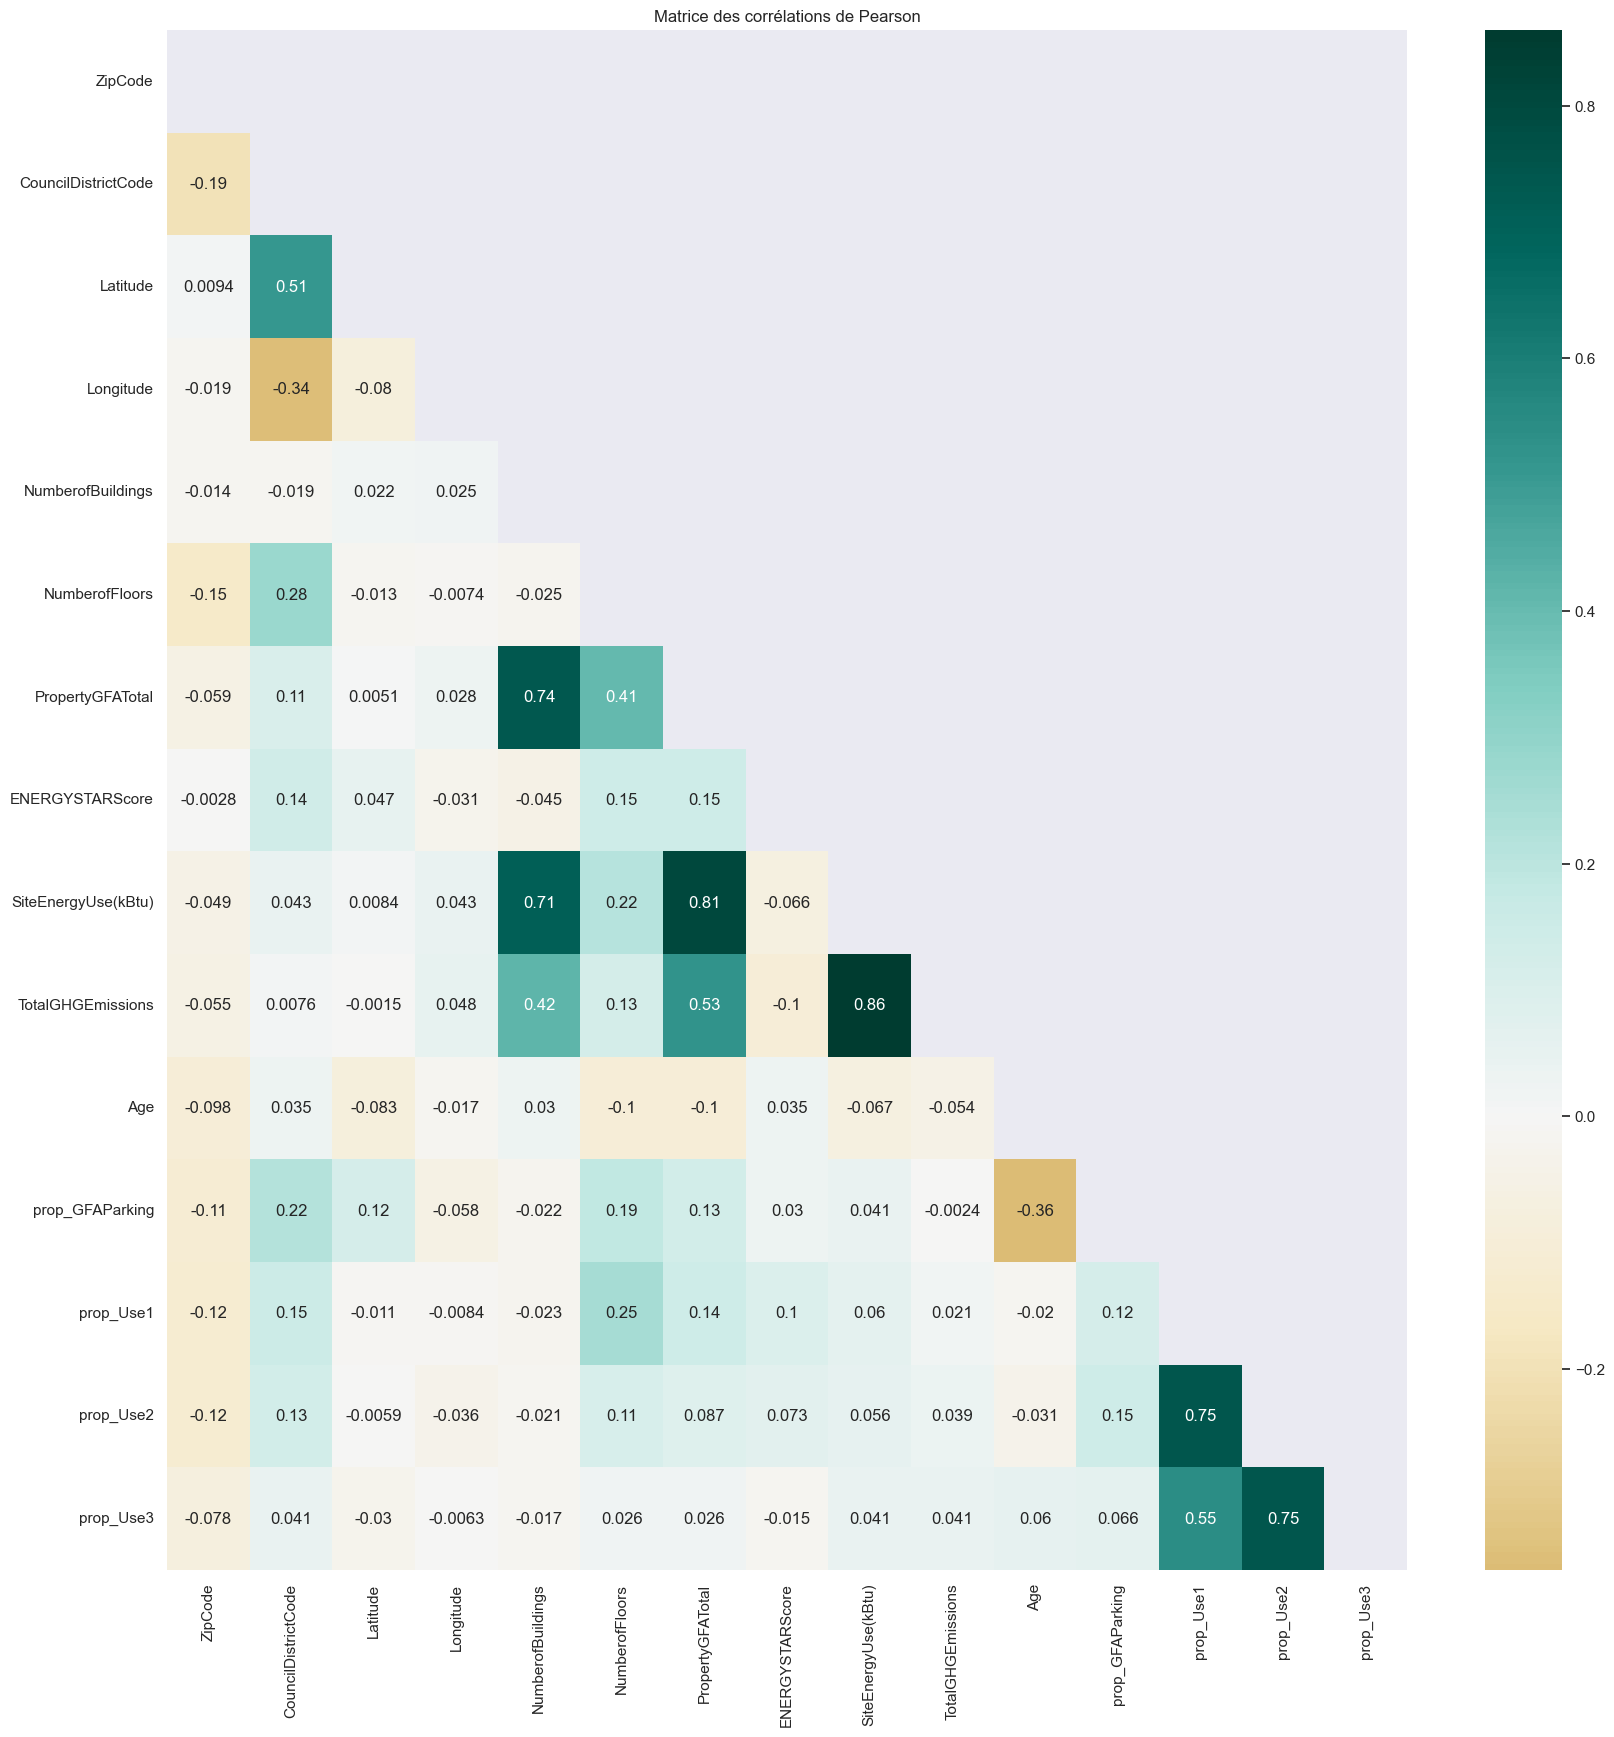

In [52]:
corr_analysis(cleandata)

Toutes les données relatives aux relevés (Electricity, Gas, Steam) ont été retirées.

## C. Map de Seattle

In [53]:
# Répartition des individus (bâtiments) sur la map de Seattle

# Coordonnées de la ville de Seattle (recherche web)
seattle_lat = 47.6062095
seattle_lon = -122.3320708

seattle_map = folium.Map(location=[seattle_lat, seattle_lon], zoom_start=11)
marker_cluster = folium.plugins.MarkerCluster().add_to(seattle_map)
for lat, lng, in zip(cleandata.Latitude, cleandata.Longitude):
    folium.Marker(location=[lat, lng]).add_to(marker_cluster)

seattle_map

# 4. Sauvegarde

In [54]:
cleandata.to_csv('cleaned_dataset.csv')